This notebook is to work out what is statistically different in the runs.
We want to calculate error bars in the DMI for the control run to see whether the experiements are statisically different
to the control. 
We will do a number of different tests:
1. take 30 year chunks of the control to estimate error bars, then se if population falls within this


In [1]:
import xarray as xr
import xesmf as xe
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import dask
import cftime
import random

In [2]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)

In [3]:
ctrl_sst = xr.open_dataset("/g/data/e14/sm2435/Exps_ACCESS_initial/ctrl_sst.nc",  use_cftime=True, chunks= {"time":240})

In [4]:
VC = xr.open_dataset("/g/data/e14/sm2435/Exps_ACCESS_initial/VAR_PACE_sst.nc",  use_cftime=True, chunks= {"time":240})
MC = xr.open_dataset("/g/data/e14/sm2435/Exps_ACCESS_initial/MC_sst.nc",  use_cftime=True, chunks= {"time":240})
OC = xr.open_dataset("/g/data/e14/sm2435/Exps_ACCESS_initial/OC_sst.nc",  use_cftime=True, chunks= {"time":240})

In [5]:
def regrid_ACCESS(ds):
    #rename coords
    ds = ds.rename({"geolon_t": "longitude", "geolat_t": "latitude"})
    #create the output grid
    ds_out = xe.util.grid_global(1, 1)
    ds_out = ds_out.drop({'lon_b', 'lat_b'})
    #rename grid coords
    ds_out = ds_out.rename({'lon': 'longitude', 'lat': 'latitude'})
    #drop the coords on input ds
    ds_in_1deg = ds.drop({'xt_ocean', 'yt_ocean'})
    #create regridder
    regridder_1deg = xe.Regridder(ds_in_1deg, ds_out, 'bilinear', periodic=True)
    #now regrid
    regridded = regridder_1deg(ds['sst'].chunk({'xt_ocean': -1, 'yt_ocean': -1}))
    regridded = regridded.assign_coords({'x': ds_out.longitude[0, :], 'y': ds_out.latitude[:, 0]})
    regridded = regridded.rename({'x': 'longitude', 'y': 'latitude'})
    return regridded

In [6]:
#VC = regrid_ACCESS(VC)
VC = VC.sst.compute()

In [7]:
#MC = regrid_ACCESS(po_pace_sst)
MC = MC.sst.compute()

In [8]:
#OC = regrid_ACCESS(oc_pace_sst)
OC = OC.sst.compute()

In [9]:
#ctrl = regrid_ACCESS(ctrl_sst)
ctrl = ctrl_sst.sst.compute()

In [10]:
def roll_longitude(df):
    """
    Rolls the longitude coordinates of a given DataFrame to a range of [0, 360).

    Parameters:
    df (xarray.DataArray): Input DataFrame containing longitude coordinates.

    Returns:
    xarray.DataArray: DataFrame with rolled longitude coordinates.
    """
    # Ensure the longitude coordinates are within the range [0, 360)
    df.coords['xt_ocean'] = (df.coords['xt_ocean']) % 360
    
    # Sort the DataFrame based on the rolled longitude coordinates
    df = df.sortby(df.xt_ocean)
    
    return df

In [11]:
ctrl = roll_longitude(ctrl)
MC = roll_longitude(MC)
VC = roll_longitude(VC)
OC = roll_longitude(OC)


In [12]:
VC = VC.rename(
    {'xt_ocean': 'longitude', 'yt_ocean': 'latitude'})
OC = OC.rename(
    {'xt_ocean': 'longitude', 'yt_ocean': 'latitude'})
MC = MC.rename(
    {'xt_ocean': 'longitude', 'yt_ocean': 'latitude'})
ctrl = ctrl.rename(
    {'xt_ocean': 'longitude', 'yt_ocean': 'latitude'})

In [13]:
s_ctrl = xr.open_dataset("/g/data/e14/sm2435/Pascal_runs/Pacemakers/REFADA_1m_000101_021012_tsurf.nc").tsurf.rename(
    {'lon': 'longitude', 'lat': 'latitude'}).sortby('latitude')
s_oc = xr.open_dataset("/g/data/e14/sm2435/Pascal_runs/Pacemakers/FTP_1m_000101_005012_tsurf.nc").tsurf.rename(
    {'lon': 'longitude', 'lat': 'latitude'}).sortby('latitude')
s_mc = xr.open_dataset("/g/data/e14/sm2435/Pascal_runs/Pacemakers/FTPC_1m_000101_011012_tsurf.nc").tsurf.rename(
    {'lon': 'longitude', 'lat': 'latitude'}).sortby('latitude')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/coding/times.py:153: SerializationWarning: Ambiguous reference date string: 1-01-31 23:54:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-01-31 23:54:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/coding/times.py:710: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axi

In [14]:
#lets clacualte the DMI first for simplicity

In [15]:
def ssta(DS):
    clim = DS.groupby('time.month').mean('time')
    ssta = DS.groupby('time.month') - clim
    return ssta.drop("month")
def NINO34_sst(DS):
     return (DS).sel(latitude=slice(-5, 5),longitude=slice(-170, -120)).mean(['latitude', 'longitude'])
def NINO34(DS):
     return ssta(DS).sel(latitude=slice(-5, 5),longitude=slice(-170, -120)).mean(['latitude', 'longitude'])
def iobm(DS):
     return ssta(DS).sel(latitude=slice(-20, 20),longitude=slice(40, 110)).mean(['latitude', 'longitude'])
    
def dmi(DS):
    WTIO = ssta(DS).sel(latitude=slice(-10, 10),longitude=slice(50, 70)).mean(['latitude', 'longitude'])
    SETIO = ssta(DS).sel(latitude=slice(-10, 0),longitude=slice(90, 110)).mean(['latitude', 'longitude'])
    return  WTIO-SETIO
def siod(DS):
    west = ssta(DS).sel(latitude=slice(-37, -27),longitude=slice(55, 65)).mean(['latitude', 'longitude'])
    east = ssta(DS).sel(latitude=slice(-28, -18),longitude=slice(90, 100)).mean(['latitude', 'longitude'])
    return  west-east
def Ningaloo2(DS):
    return ssta(DS).sel(latitude=slice(-28, -22),longitude=slice(112, 114)).mean(['latitude', 'longitude'])

In [16]:
def EIO(DS):
    SETIO = ssta(DS).sel(latitude=slice(-10, 0),longitude=slice(90, 110)).mean(['latitude', 'longitude'])
    return  SETIO

In [17]:
def WIO(DS):
    WTIO = ssta(DS).sel(latitude=slice(-10, 10),longitude=slice(50, 70)).mean(['latitude', 'longitude'])
    return  WTIO

In [18]:
from scipy.stats import skew

In [19]:
(dmi(s_ctrl)).std()

<xarray.DataArray 'tsurf' ()>
array(0.4001818)

In [20]:
(dmi(s_oc)).std()

<xarray.DataArray 'tsurf' ()>
array(0.38635242)

In [21]:
(dmi(s_mc)).std()

<xarray.DataArray 'tsurf' ()>
array(0.36690751)

In [22]:
(dmi(VC)).std()

<xarray.DataArray 'sst' ()>
array(0.4428117)

In [23]:
skew(dmi(ctrl))

0.4200897169778717

In [24]:
skew(dmi(OC))

0.012336143589923448

In [25]:
skew(dmi(VC))

0.7316318304940432

In [26]:
skew(dmi(MC))

0.14366805798185536

In [27]:
skew(dmi(s_ctrl))

-0.1028133801114641

In [28]:
skew(dmi(s_oc))

0.1160936125076254

In [29]:
skew(dmi(s_mc))

-0.03341559490049502

In [19]:
skew(EIO(ctrl))

-0.4301075749356114

In [20]:
skew(EIO(OC))

0.09579141829665548

In [21]:
skew(EIO(VC))

-0.6305642849191433

In [22]:
skew(EIO(MC))

-0.47915137930128626

In [23]:
skew(EIO(s_ctrl))

-0.18493318318456844

In [24]:
skew(EIO(s_oc))

-0.17228516934666832

In [25]:
skew(EIO(s_mc))

0.10414465225949522

In [26]:
skew(WIO(ctrl))

-0.13617920346706683

In [27]:
skew(WIO(OC))

0.05043968554510273

In [28]:
skew(WIO(VC))

-0.19435551006028154

In [29]:
skew(WIO(MC))

-0.08783140199028674

In [30]:
skew(WIO(s_ctrl))

-0.1832585952160981

In [31]:
skew(WIO(s_oc))

-0.047979800532521454

In [32]:
skew(WIO(s_mc))

-0.016976415265940344

In [54]:
def IOD_events(ds):
    """
    Identifies Indian Ocean Dipole (IOD) events based on the Dipole Mode Index (DMI) timeseries within specific seasons.

    Parameters:
    ds (xarray.Dataset): Input dataset containing the Dipole Mode Index (DMI) values.

    Returns:
    tuple: Two DataArrays representing negative (nIOD) and positive (pIOD) IOD events.
    """
    # Get the DMI timeseries in seasons starting from DJF, MAM, etc.
    QS = dmi(ds).resample(time='QS-DEC').mean(dim="time")
    
    # Select SON seasons into a timeseries
    SON = QS.groupby('time.season')["SON"]
    
    # Use quantiles to select all events and create DataArrays of nIOD and pIOD event values
    #lower, upper = SON.quantile([0.2, 0.8])
    nIOD = SON.where(SON <= -0.4001818).dropna(dim="time")
    pIOD = SON.where(SON > 0.4001818).dropna(dim="time")
    
    return nIOD, pIOD

In [34]:
def no_p_n_iod_norm(ds):
    n,p = IOD_events(ds)
    yrs = len(ds.time)/12
    n1 = len(n)/yrs *100
    p1 = len(p)/yrs *100
    return p1, n1

In [55]:
no_p_n_iod_norm(ctrl)

(22.885572139303484, 22.885572139303484)

In [56]:
no_p_n_iod_norm(OC)

(12.857142857142856, 14.285714285714285)

In [57]:
no_p_n_iod_norm(MC)

(18.954248366013072, 18.954248366013072)

In [58]:
no_p_n_iod_norm(VC)

(22.857142857142858, 22.857142857142858)

In [59]:
no_p_n_iod_norm(s_ctrl)

(13.333333333333334, 15.238095238095239)

In [60]:
no_p_n_iod_norm(s_oc)

(10.0, 20.0)

In [61]:
no_p_n_iod_norm(s_mc)

(10.0, 9.090909090909092)

In [42]:
DMI = dmi(ctrl)

Look at if the standard deviation difference between contorl bootstraps (30yrs) and control (200 yrs) is different in any of the experiments. ie outside of the 5 95 %ile


In [43]:
def bootstrap_index(ds, num_years):
    # Step 1: Number of iterations
    num_iterations = 1000
    # Step 2: loop over the number of iterations
    std_deviations = []
    for _ in range(num_iterations):
        # Step 2: Randomly select 30 years with replacement
        random_years = np.random.choice(ds['time.year'], size=num_years, replace=True)

        # Step 3: Calculate the standard deviation for the selected 30 years
        selected_years_data = DMI.sel(time=np.isin(ds['time.year'], random_years))
        std_dev = selected_years_data.std(dim='time')

        # Step 4: Store the standard deviation value
        std_deviations.append(selected_years_data)
    return xr.concat(std_deviations, dim = 'it')

In [14]:
dmi_48 = bootstrap_index(DMI, 69)

In [15]:
dmi_48

<xarray.DataArray (it: 1000, time: 2412)>
array([[       nan,        nan,        nan, ..., 0.82120407, 0.37125218,
        0.13151374],
       [       nan,        nan,        nan, ..., 0.82120407, 0.37125218,
        0.13151374],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ..., 0.82120407, 0.37125218,
        0.13151374],
       [       nan,        nan,        nan, ..., 0.82120407, 0.37125218,
        0.13151374],
       [0.18244019, 0.08512398, 0.1274277 , ...,        nan,        nan,
               nan]], dtype=float32)
Coordinates:
  * time     (time) object 0950-01-16 12:00:00 ... 1150-12-16 12:00:00
Dimensions without coordinates: it

In [16]:
DMI_pos = DMI.where(DMI >0, DMI*-1)

In [17]:
dmi_48_pos = bootstrap_index(DMI_pos, 70)

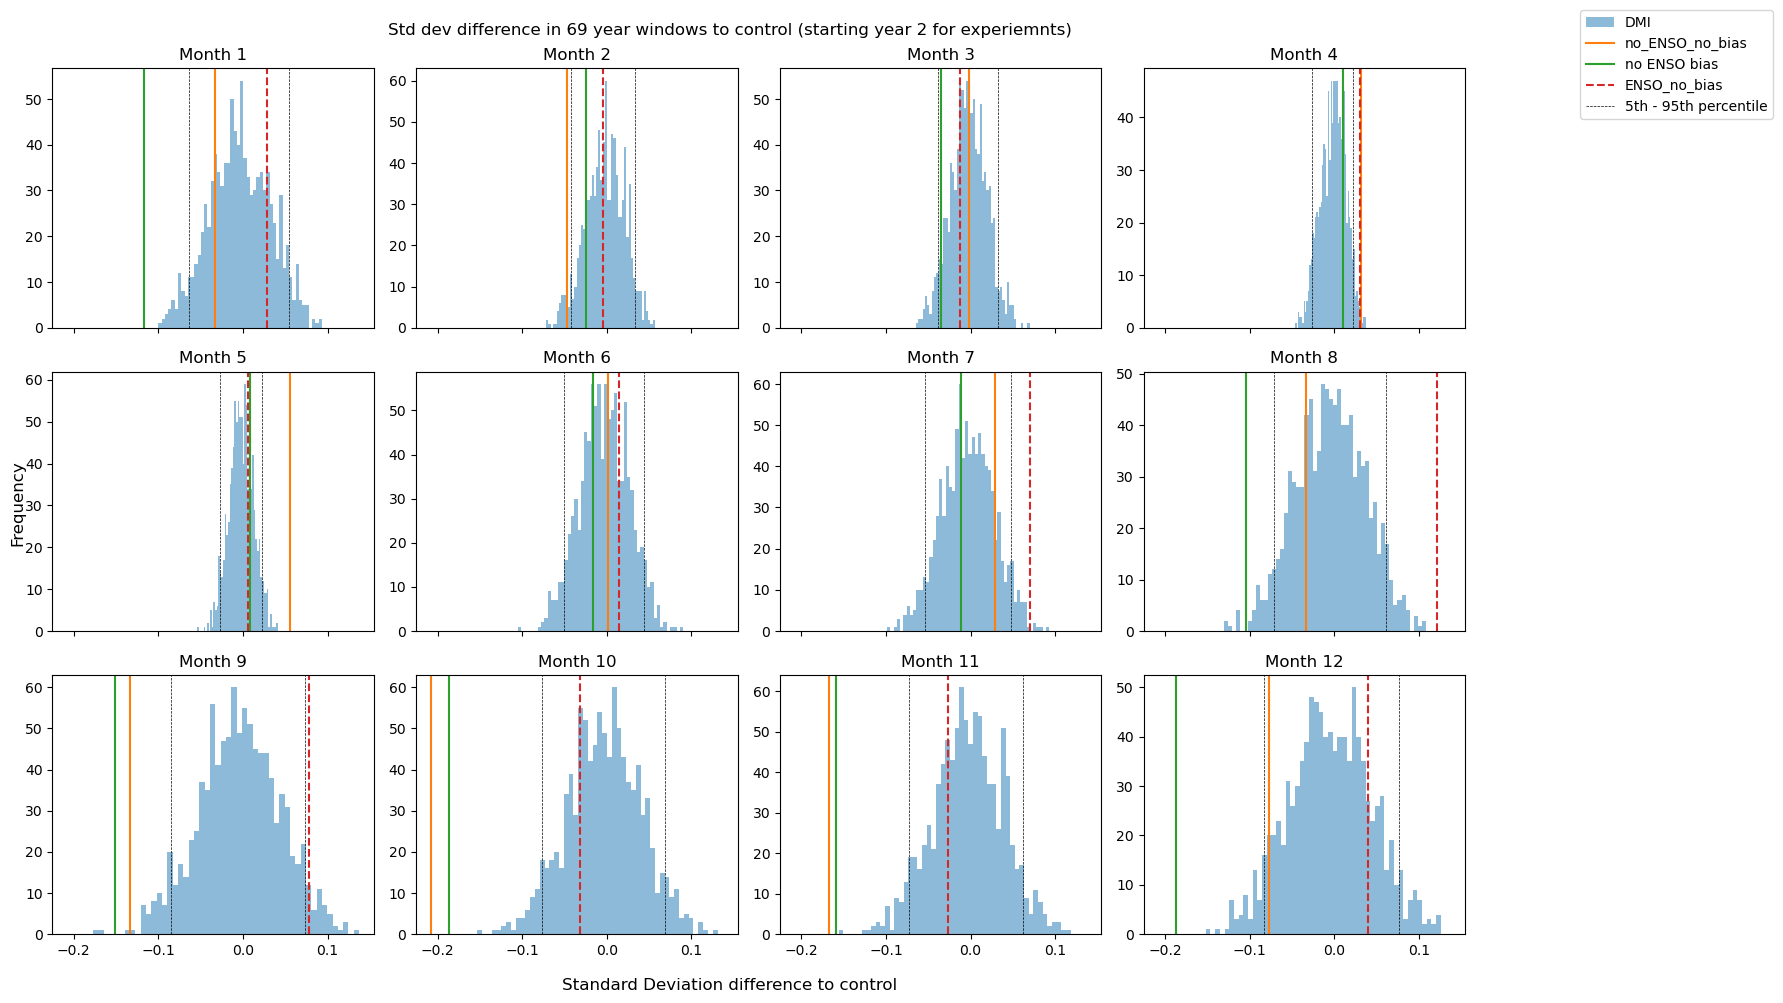

In [20]:
# Calculate the standard deviation for each month for both DMI and dmi_30
std_monthly_DMI = DMI.groupby('time.month').std('time')
std_monthly_dmi_30 = dmi_48.groupby('time.month').std('time')

# Create a facet plot
fig, axes = plt.subplots(nrows=3, ncols = 4, figsize=(15, 10), sharex=True)

# Calculate the standard deviation difference for the monhtly montecarlo of control
std_diff = std_monthly_dmi_30 - std_monthly_DMI
# Calculate quantiles
quants = std_diff.quantile([0.05, 0.95], dim='it')
# Calculate differences for each run to the control
VC_diff = dmi(VC.sel(time=slice("0952-01-01", "1020-12-31"))).groupby('time.month').std('time') - std_monthly_DMI
OC_diff = dmi(OC.sel(time=slice("0952-01-01", "1020-12-31"))).groupby('time.month').std('time') - std_monthly_DMI
MC_diff = dmi(MC.sel(time=slice("0952-01-01", "1020-12-31"))).groupby('time.month').std('time') - std_monthly_DMI

# Iterate through months and plot
for month in range(1, 13):
    row = (month - 1) // 4 
    col = (month - 1) % 4
    std_diff.sel(month=month).plot.hist(bins=50, ax=axes[row, col], alpha=0.5, label='DMI')
    # Add vertical lines for quantiles and other values
    axes[row, col].axvline(OC_diff.sel(month = month), c='tab:orange', label="no_ENSO_no_bias")
    axes[row, col].axvline(MC_diff.sel(month = month), c='tab:green', label="no ENSO bias")
    axes[row, col].axvline(VC_diff.sel(month = month), c='tab:red',ls='--', label="ENSO_no_bias")

    axes[row, col].axvline(quants.sel(month = month)[0], c='k', ls='--', lw=0.5, label="5th - 95th percentile")
    axes[row, col].axvline(quants.sel(month = month)[1], c='k', ls='--', lw=0.5)
    axes[row, col].set_title(f"Month {month}")

# Create a common legend outside the subplots
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.2, 1))

# Set common labels and layout
fig.suptitle("Std dev difference in 69 year windows to control (starting year 2 for experiemnts)")
fig.supxlabel("Standard Deviation difference to control")
fig.supylabel("Frequency")
plt.tight_layout()
plt.show()

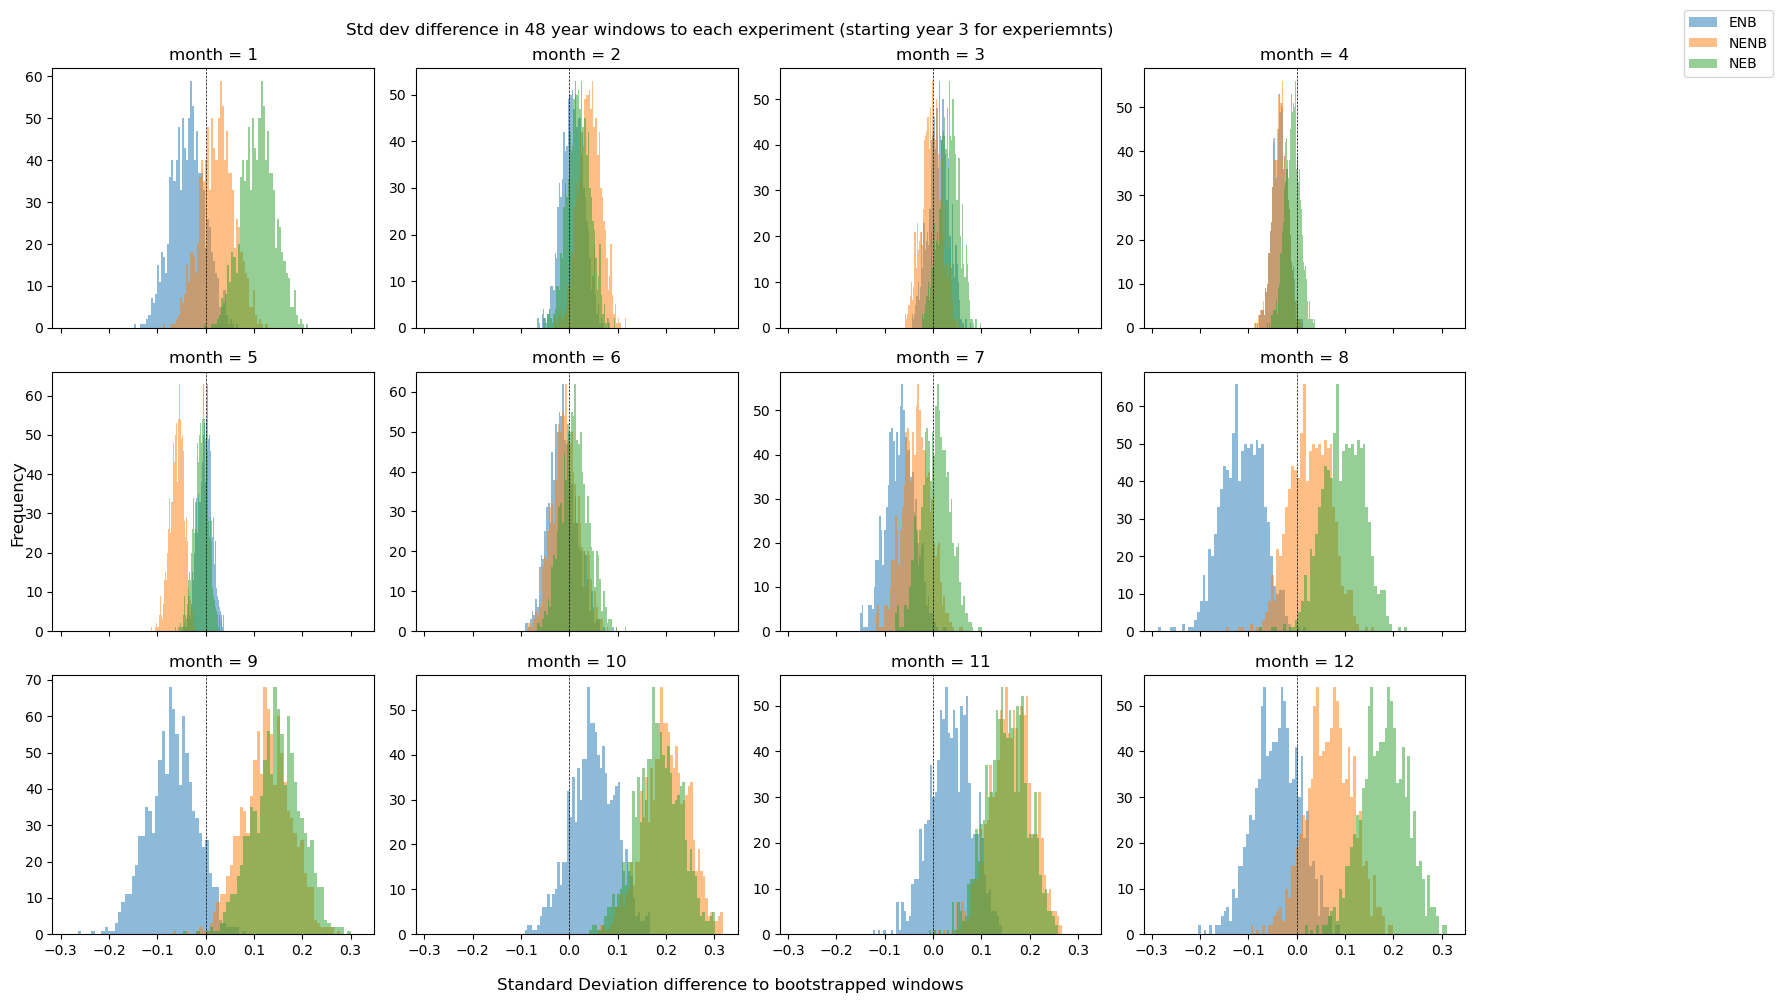

In [17]:
fig, axes = plt.subplots(nrows=3, ncols = 4, figsize=(15, 10), sharex=True)
for month in range(1, 13):
    row = (month - 1) // 4 
    col = (month - 1) % 4
    (dmi_48.groupby("time.month").std('time') - dmi(VC.sel(time=slice("0953-01-01", "1020-12-31"))).groupby("time.month").std('time')).sel(month=month).plot.hist(
        bins=50, ax=axes[row, col], alpha=0.5, label='ENB')
    (dmi_48.groupby("time.month").std('time') - dmi(OC.sel(time=slice("0953-01-01", "1020-12-31"))).groupby("time.month").std('time')).sel(month=month).plot.hist(
        bins=50, ax=axes[row, col], alpha=0.5, label='NENB')
    (dmi_48.groupby("time.month").std('time') - dmi(MC.sel(time=slice("0953-01-01", "1020-12-31"))).groupby("time.month").std('time')).sel(month=month).plot.hist(
        bins=50, ax=axes[row, col], alpha=0.5, label='NEB')
    axes[row, col].axvline(0, c='k', ls='--', lw=0.5)
# Create a common legend outside the subplots
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.2, 1))

# Set common labels and layout
fig.suptitle("Std dev difference in 48 year windows to each experiment (starting year 3 for experiemnts)")
fig.supxlabel("Standard Deviation difference to bootstrapped windows")
fig.supylabel("Frequency")
plt.tight_layout()
plt.show()

NameError: name 'dmi_30' is not defined

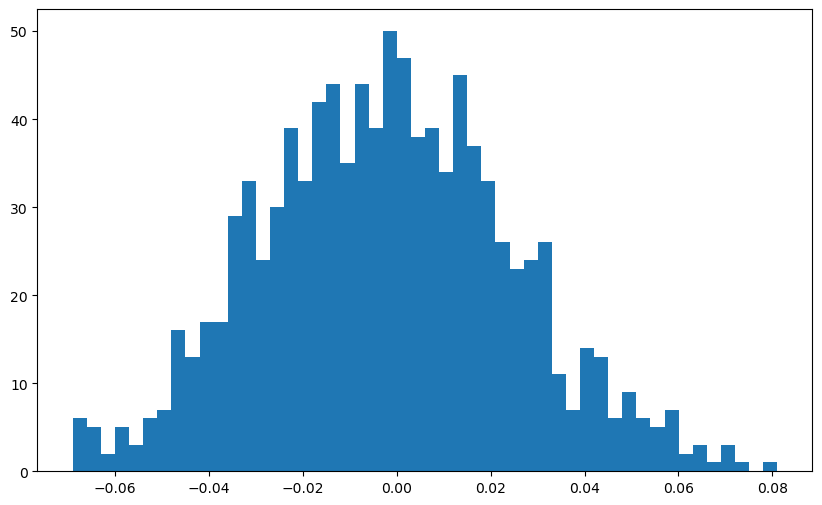

In [20]:
#now plot the difference to whole control
plt.figure(figsize = (10,6))
(dmi_48.std('time') - DMI.std('time')).plot.hist(bins = 50)
quants = (dmi_30.std('time') - DMI.std('time')).quantile([0.05,0.95], dim = 'it')
plt.axvline(quants[0], c = 'k', ls = '--', lw = 0.5, label = "5th - 95th percentile")
plt.axvline(quants[1], c = 'k', ls = '--', lw = 0.5)
plt.axvline(dmi(VC.sel(time=slice("0953-01-01", "1000-12-31"))).std('time')- DMI.std('time'), c = 'tab:red', label = "ENSO_no_bias")
plt.axvline(dmi(OC.sel(time=slice("0953-01-01", "1000-12-31"))).std('time')- DMI.std('time'), c = 'tab:orange', label = "no_ENSO_no_bias")
plt.axvline(dmi(MC.sel(time=slice("0953-01-01", "1000-12-31"))).std('time')- DMI.std('time'), c= "tab:green", label = "no_ENSO_with_bias")
plt.legend()
plt.title("difference in standard deviation to control"
          "\nstandard deviation difference of 48 year windows in the control to the control (blue)")

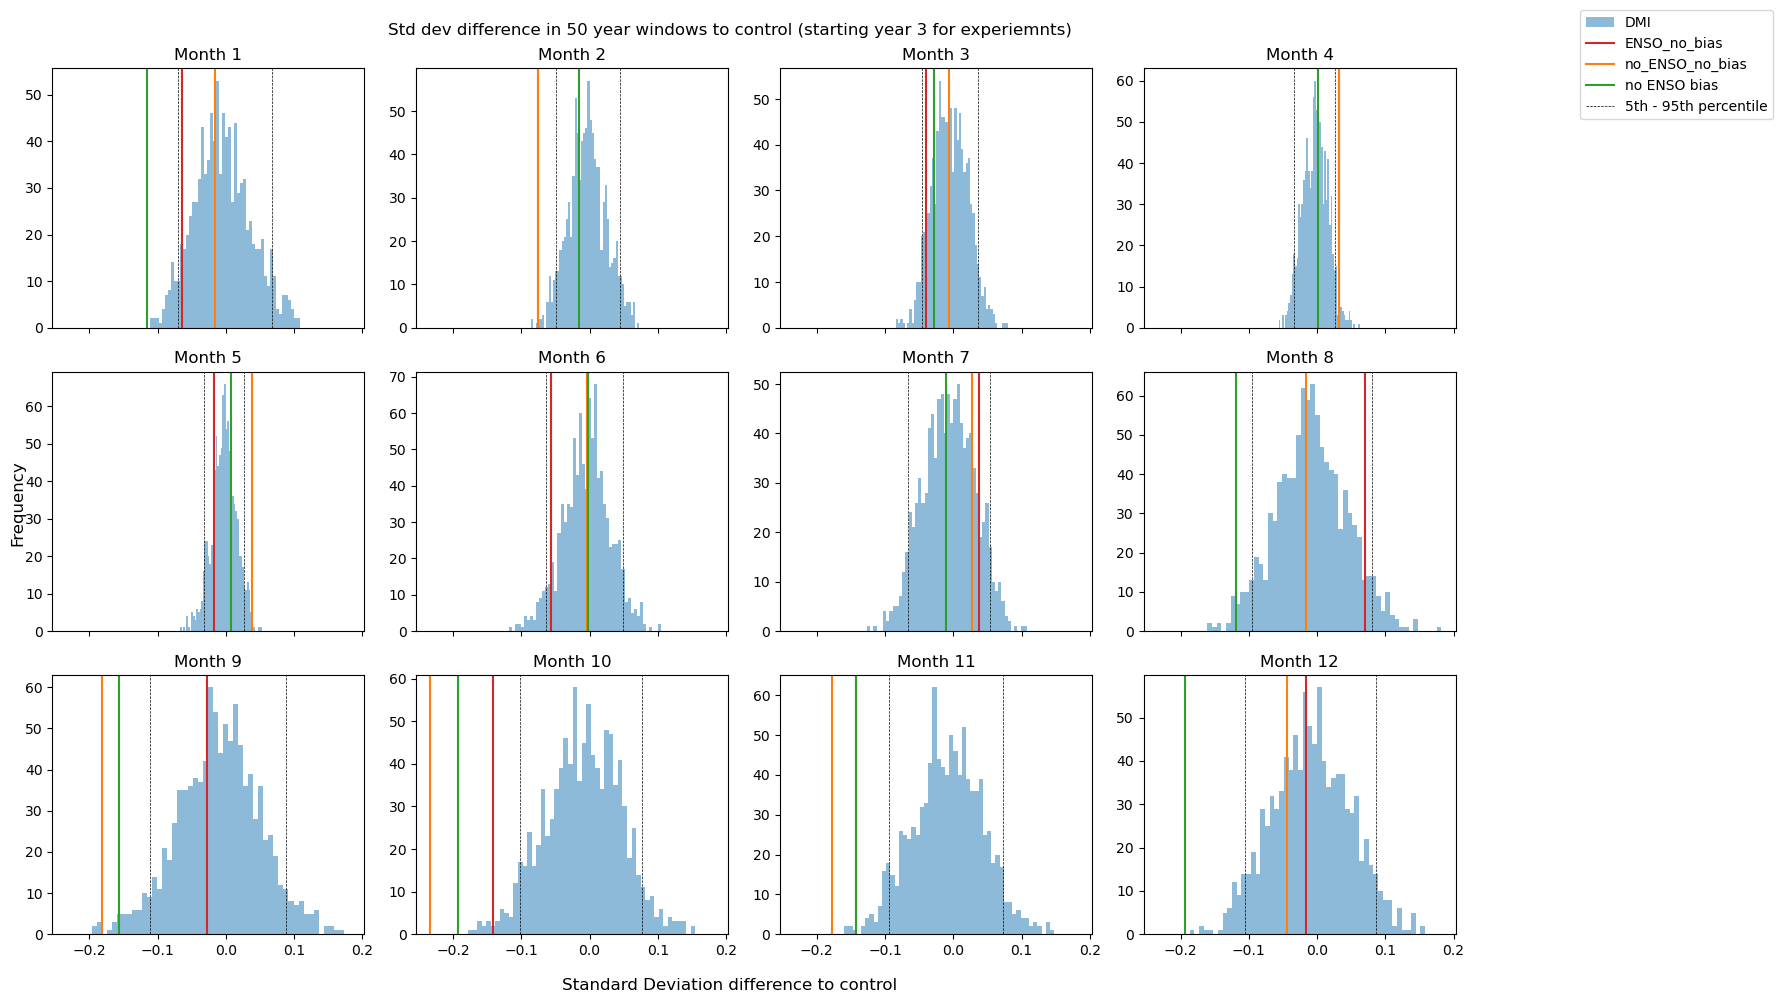

In [41]:
# Calculate the standard deviation for each month for both DMI and dmi_30
std_monthly_DMI = DMI.groupby('time.month').std('time')
std_monthly_dmi_30 = dmi_50.groupby('time.month').std('time')

# Create a facet plot
fig, axes = plt.subplots(nrows=3, ncols = 4, figsize=(15, 10), sharex=True)

# Calculate the standard deviation difference for the monhtly montecarlo of control
std_diff = std_monthly_dmi_30 - std_monthly_DMI
# Calculate quantiles
quants = std_diff.quantile([0.05, 0.95], dim='it')
# Calculate differences for each run to the control
VC_diff = dmi(VC.sel(time=slice("0953-01-01", "0980-12-31"))).groupby('time.month').std('time') - std_monthly_DMI
OC_diff = dmi(OC.sel(time=slice("0953-01-01", "0980-12-31"))).groupby('time.month').std('time') - std_monthly_DMI
MC_diff = dmi(MC.sel(time=slice("0953-01-01", "0980-12-31"))).groupby('time.month').std('time') - std_monthly_DMI
MC_diff1 = dmi(MC.sel(time=slice("0953-01-01", "1000-12-31"))).groupby('time.month').std('time') - std_monthly_DMI

# Iterate through months and plot
for month in range(1, 13):
    row = (month - 1) // 4 
    col = (month - 1) % 4
    std_diff.sel(month=month).plot.hist(bins=50, ax=axes[row, col], alpha=0.5, label='DMI')
    # Add vertical lines for quantiles and other values
    axes[row, col].axvline(VC_diff.sel(month = month), c='tab:red', label="ENSO_no_bias")
    axes[row, col].axvline(OC_diff.sel(month = month), c='tab:orange', label="no_ENSO_no_bias")
    axes[row, col].axvline(MC_diff1.sel(month = month), c='tab:green', label="no ENSO bias")
    axes[row, col].axvline(quants.sel(month = month)[0], c='k', ls='--', lw=0.5, label="5th - 95th percentile")
    axes[row, col].axvline(quants.sel(month = month)[1], c='k', ls='--', lw=0.5)
    axes[row, col].set_title(f"Month {month}")

# Create a common legend outside the subplots
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.2, 1))

# Set common labels and layout
fig.suptitle("Std dev difference in 50 year windows to control (starting year 3 for experiemnts)")
fig.supxlabel("Standard Deviation difference to control")
fig.supylabel("Frequency")
plt.tight_layout()
plt.show()

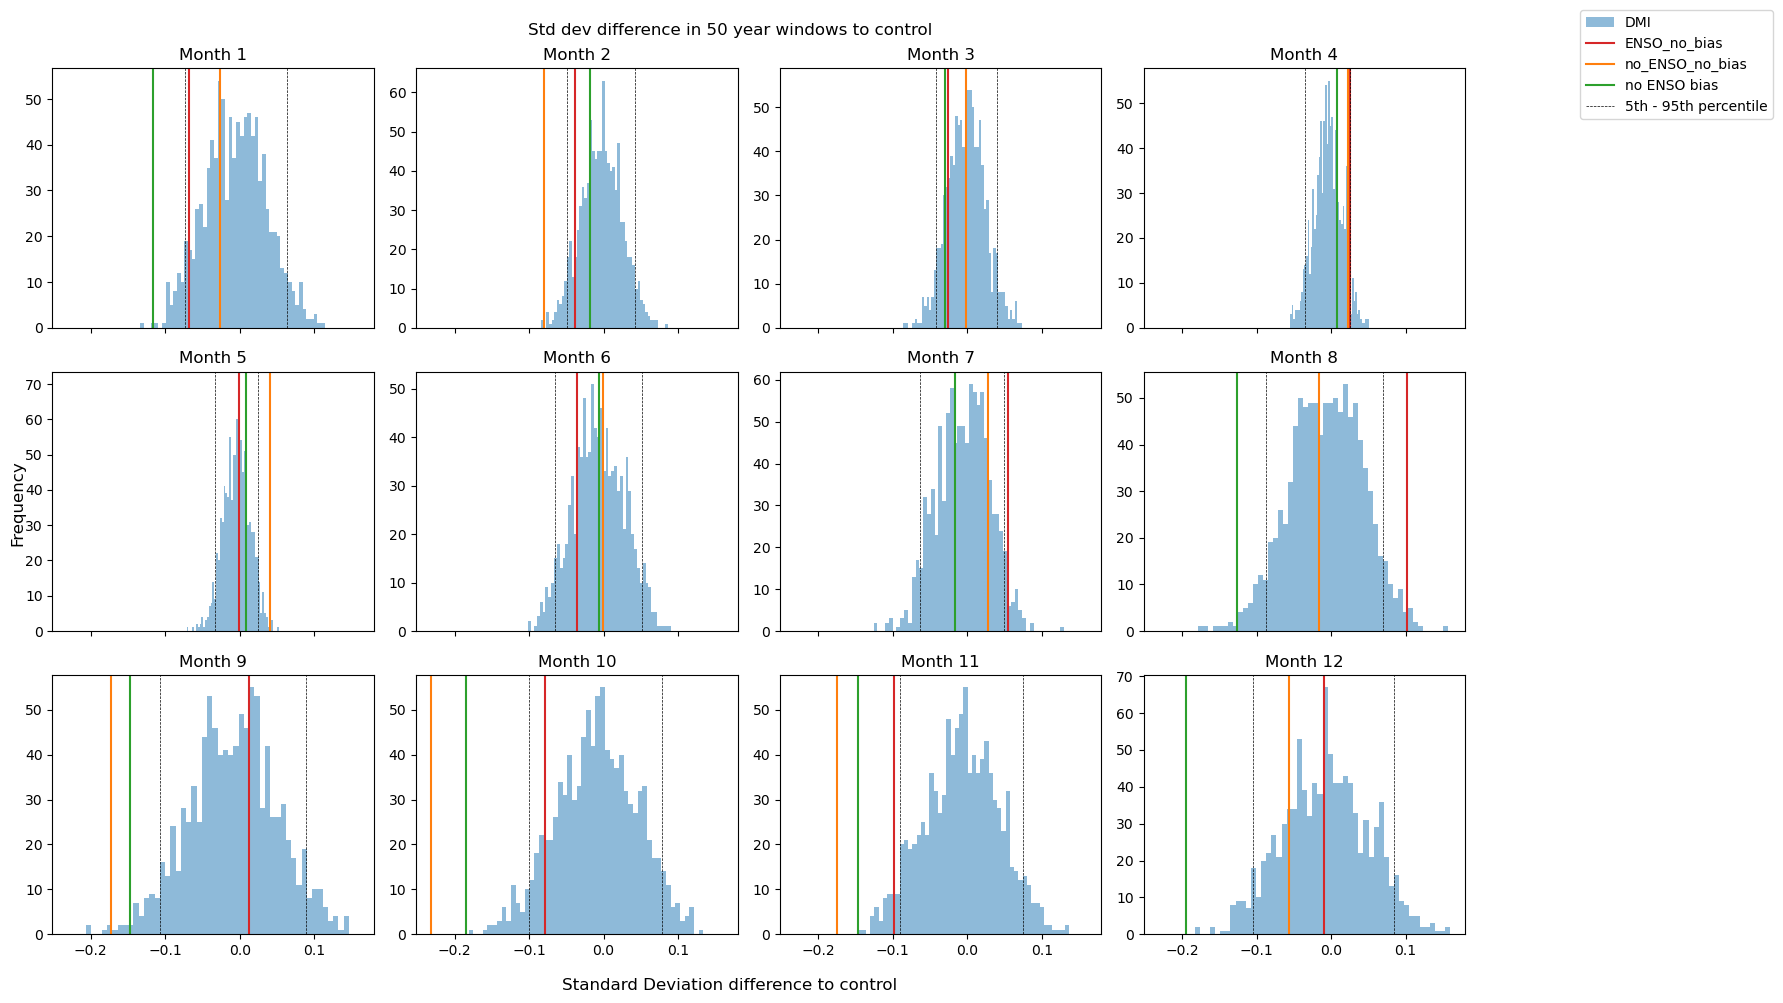

In [17]:
# Calculate the standard deviation for each month for both DMI and dmi_30
std_monthly_DMI = DMI.groupby('time.month').std('time')
std_monthly_dmi_30 = dmi_50.groupby('time.month').std('time')

# Create a facet plot
fig, axes = plt.subplots(nrows=3, ncols = 4, figsize=(15, 10), sharex=True)

# Calculate the standard deviation difference for the monhtly montecarlo of control
std_diff = std_monthly_dmi_30 - std_monthly_DMI
# Calculate quantiles
quants = std_diff.quantile([0.05, 0.95], dim='it')
# Calculate differences for each run to the control
VC_diff = dmi(VC).groupby('time.month').std('time') - std_monthly_DMI
OC_diff = dmi(OC).groupby('time.month').std('time') - std_monthly_DMI
MC_diff = dmi(MC).groupby('time.month').std('time') - std_monthly_DMI
MC_diff1 = dmi(MC.sel(time=slice("0951-01-01", "1000-12-31"))).groupby('time.month').std('time') - std_monthly_DMI

# Iterate through months and plot
for month in range(1, 13):
    row = (month - 1) // 4 
    col = (month - 1) % 4
    std_diff.sel(month=month).plot.hist(bins=50, ax=axes[row, col], alpha=0.5, label='DMI')
    # Add vertical lines for quantiles and other values
    axes[row, col].axvline(VC_diff.sel(month = month), c='tab:red', label="ENSO_no_bias")
    axes[row, col].axvline(OC_diff.sel(month = month), c='tab:orange', label="no_ENSO_no_bias")
    axes[row, col].axvline(MC_diff1.sel(month = month), c='tab:green', label="no ENSO bias")
    axes[row, col].axvline(quants.sel(month = month)[0], c='k', ls='--', lw=0.5, label="5th - 95th percentile")
    axes[row, col].axvline(quants.sel(month = month)[1], c='k', ls='--', lw=0.5)
    axes[row, col].set_title(f"Month {month}")

# Create a common legend outside the subplots
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.2, 1))

# Set common labels and layout
fig.suptitle("Std dev difference in 50 year windows to control")
fig.supxlabel("Standard Deviation difference to control")
fig.supylabel("Frequency")
plt.tight_layout()
plt.show()

Text(0.5, 1.0, '50 Year window, November')

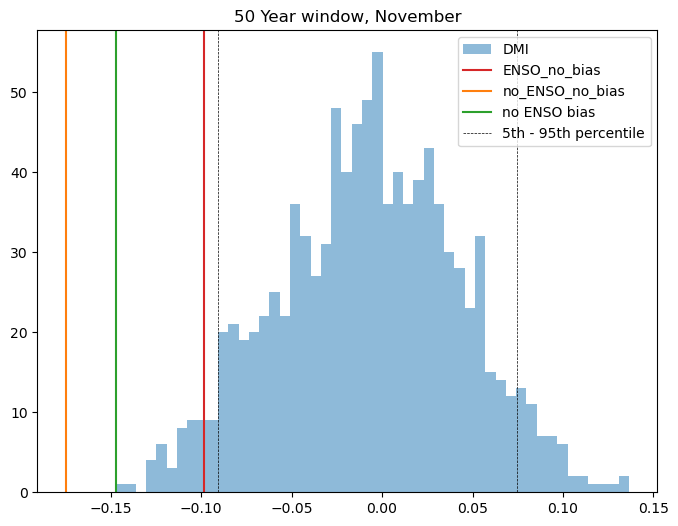

In [18]:
plt.figure(figsize = (8,6))
std_diff.sel(month=11).plot.hist(bins=50,alpha=0.5, label='DMI')
# Add vertical lines for quantiles and other values
plt.axvline(VC_diff.sel(month = 11), c='tab:red', label="ENSO_no_bias")
plt.axvline(OC_diff.sel(month = 11), c='tab:orange', label="no_ENSO_no_bias")
plt.axvline(MC_diff1.sel(month = 11), c='tab:green', label="no ENSO bias")
plt.axvline(quants.sel(month = 11)[0], c='k', ls='--', lw=0.5, label="5th - 95th percentile")
plt.axvline(quants.sel(month = 11)[1], c='k', ls='--', lw=0.5)
plt.legend()
plt.title("50 Year window, November")

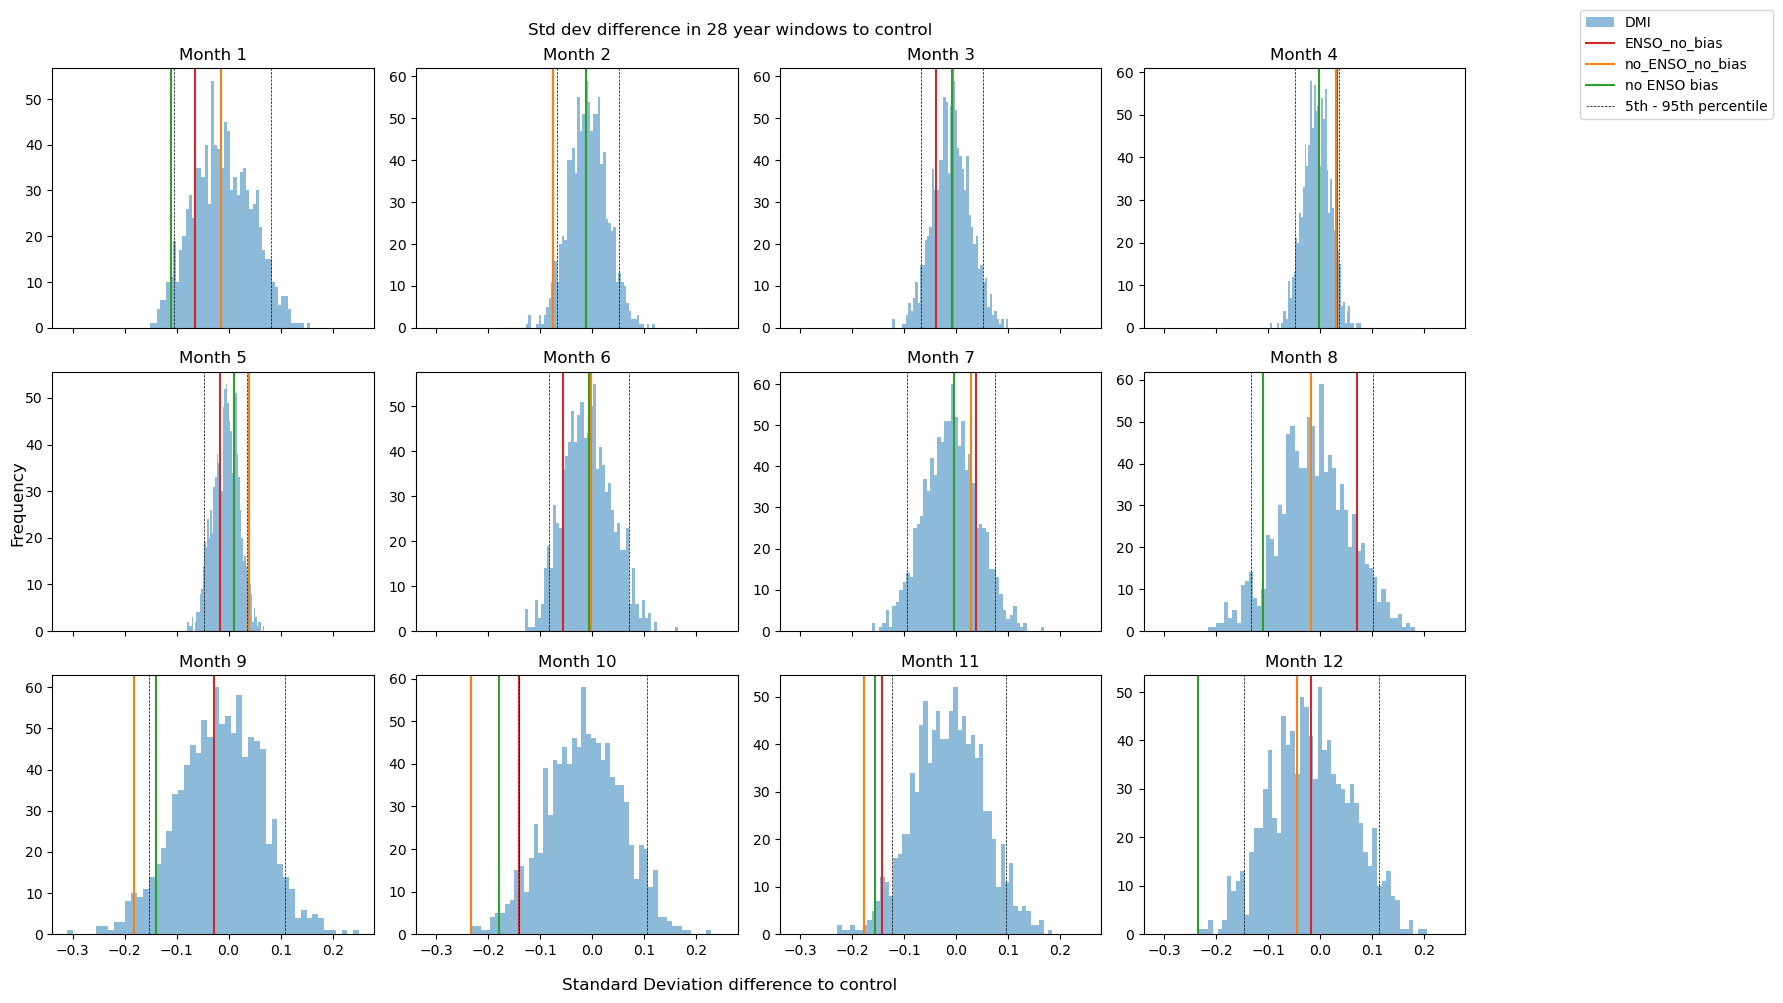

In [40]:
# Calculate the standard deviation for each month for both DMI and dmi_30
std_monthly_DMI = DMI.groupby('time.month').std('time')
std_monthly_dmi_30 = dmi_28.groupby('time.month').std('time')

# Create a facet plot
fig, axes = plt.subplots(nrows=3, ncols = 4, figsize=(15, 10), sharex=True)

# Calculate the standard deviation difference for the monhtly montecarlo of control
std_diff = std_monthly_dmi_30 - std_monthly_DMI
# Calculate quantiles
quants = std_diff.quantile([0.05, 0.95], dim='it')
# Calculate differences for each run to the control
VC_diff = dmi(VC.sel(time=slice("0953-01-01", "0980-12-31"))).groupby('time.month').std('time') - std_monthly_DMI
OC_diff = dmi(OC.sel(time=slice("0953-01-01", "0980-12-31"))).groupby('time.month').std('time') - std_monthly_DMI
MC_diff = dmi(MC).groupby('time.month').std('time') - std_monthly_DMI
MC_diff1 = dmi(MC.sel(time=slice("0953-01-01", "0980-12-31"))).groupby('time.month').std('time') - std_monthly_DMI

# Iterate through months and plot
for month in range(1, 13):
    row = (month - 1) // 4 
    col = (month - 1) % 4
    std_diff.sel(month=month).plot.hist(bins=50, ax=axes[row, col], alpha=0.5, label='DMI')
    # Add vertical lines for quantiles and other values
    axes[row, col].axvline(VC_diff.sel(month = month), c='tab:red', label="ENSO_no_bias")
    axes[row, col].axvline(OC_diff.sel(month = month), c='tab:orange', label="no_ENSO_no_bias")
    axes[row, col].axvline(MC_diff1.sel(month = month), c='tab:green', label="no ENSO bias")
    axes[row, col].axvline(quants.sel(month = month)[0], c='k', ls='--', lw=0.5, label="5th - 95th percentile")
    axes[row, col].axvline(quants.sel(month = month)[1], c='k', ls='--', lw=0.5)
    axes[row, col].set_title(f"Month {month}")

# Create a common legend outside the subplots
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.2, 1))

# Set common labels and layout
fig.suptitle("Std dev difference in 28 year windows to control")
fig.supxlabel("Standard Deviation difference to control")
fig.supylabel("Frequency")
plt.tight_layout()
plt.show()

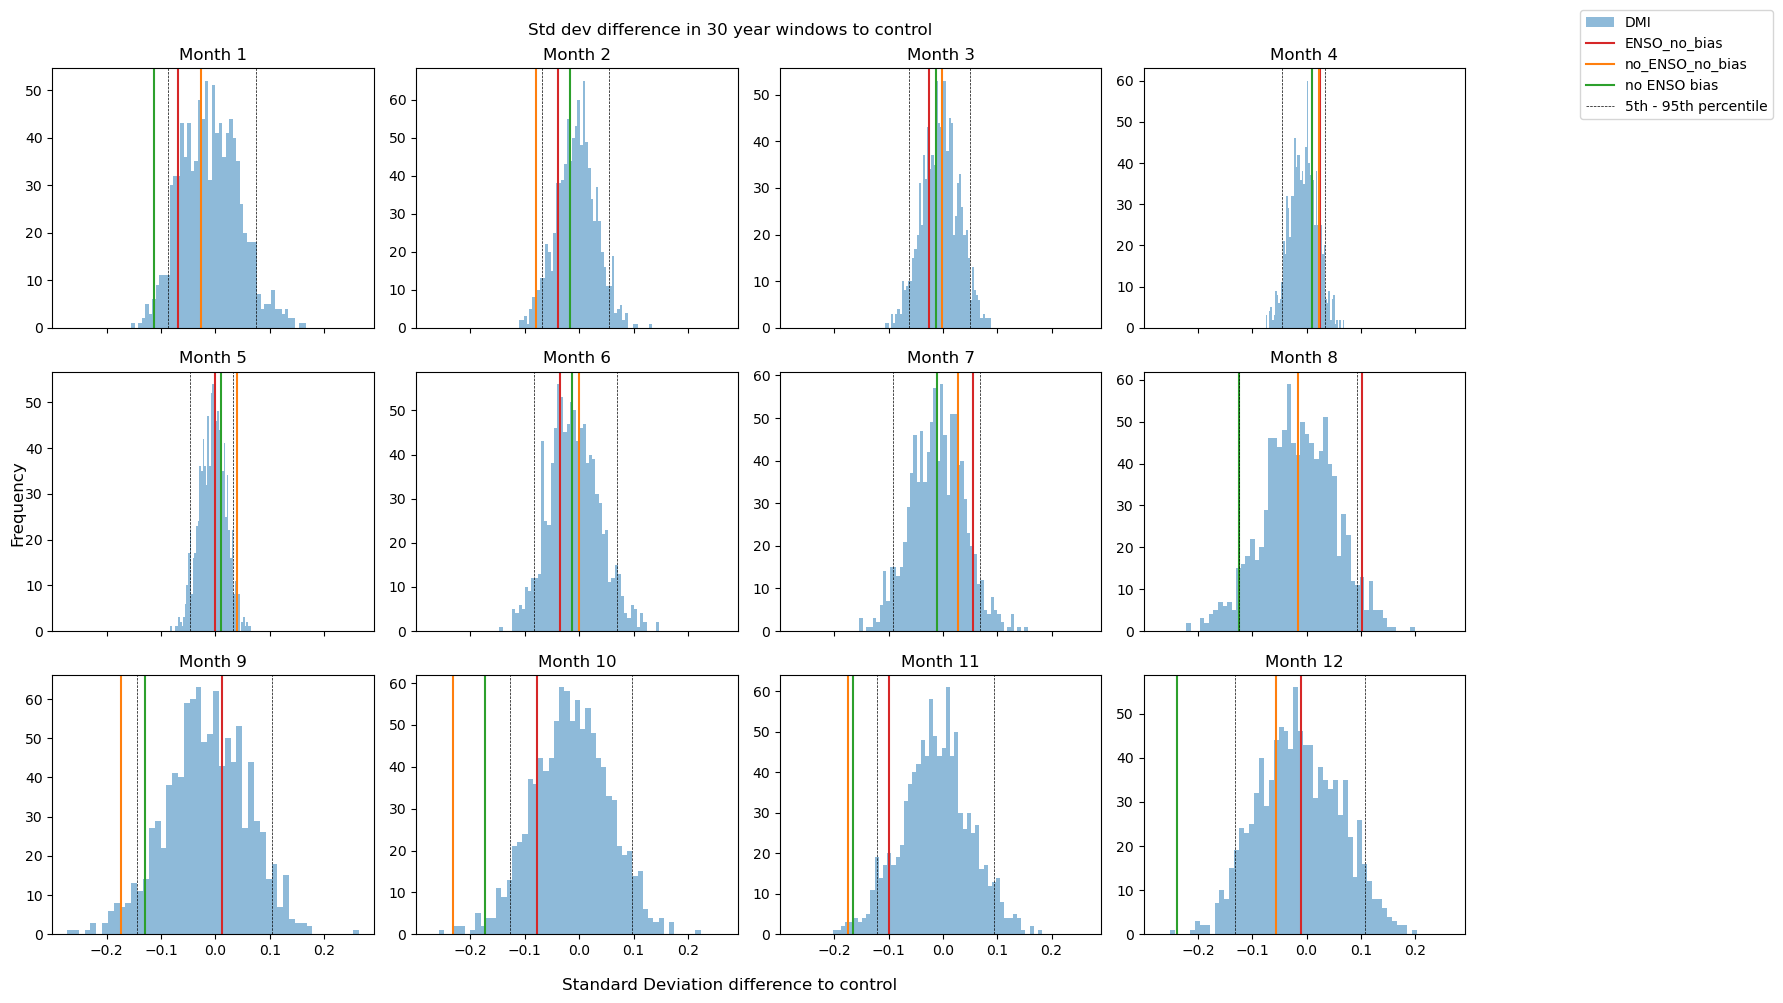

In [19]:
# Calculate the standard deviation for each month for both DMI and dmi_30
std_monthly_DMI = DMI.groupby('time.month').std('time')
std_monthly_dmi_30 = dmi_30.groupby('time.month').std('time')

# Create a facet plot
fig, axes = plt.subplots(nrows=3, ncols = 4, figsize=(15, 10), sharex=True)

# Calculate the standard deviation difference for the monhtly montecarlo of control
std_diff = std_monthly_dmi_30 - std_monthly_DMI
# Calculate quantiles
quants = std_diff.quantile([0.05, 0.95], dim='it')
# Calculate differences for each run to the control
VC_diff = dmi(VC).groupby('time.month').std('time') - std_monthly_DMI
OC_diff = dmi(OC).groupby('time.month').std('time') - std_monthly_DMI
MC_diff = dmi(MC).groupby('time.month').std('time') - std_monthly_DMI
MC_diff1 = dmi(MC.sel(time=slice("0951-01-01", "0980-12-31"))).groupby('time.month').std('time') - std_monthly_DMI

# Iterate through months and plot
for month in range(1, 13):
    row = (month - 1) // 4 
    col = (month - 1) % 4
    std_diff.sel(month=month).plot.hist(bins=50, ax=axes[row, col], alpha=0.5, label='DMI')
    # Add vertical lines for quantiles and other values
    axes[row, col].axvline(VC_diff.sel(month = month), c='tab:red', label="ENSO_no_bias")
    axes[row, col].axvline(OC_diff.sel(month = month), c='tab:orange', label="no_ENSO_no_bias")
    axes[row, col].axvline(MC_diff1.sel(month = month), c='tab:green', label="no ENSO bias")
    axes[row, col].axvline(quants.sel(month = month)[0], c='k', ls='--', lw=0.5, label="5th - 95th percentile")
    axes[row, col].axvline(quants.sel(month = month)[1], c='k', ls='--', lw=0.5)
    axes[row, col].set_title(f"Month {month}")

# Create a common legend outside the subplots
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.2, 1))

# Set common labels and layout
fig.suptitle("Std dev difference in 30 year windows to control")
fig.supxlabel("Standard Deviation difference to control")
fig.supylabel("Frequency")
plt.tight_layout()
plt.show()

In [201]:
DMI.groupby("time.month").std("time")

<xarray.DataArray (month: 12)>
array([0.3546015 , 0.29124007, 0.27009299, 0.24090621, 0.2054197 ,
       0.31971085, 0.37537968, 0.53082049, 0.61734653, 0.58971095,
       0.52745348, 0.49895719])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

Text(0.5, 1.0, '30 Year window, November')

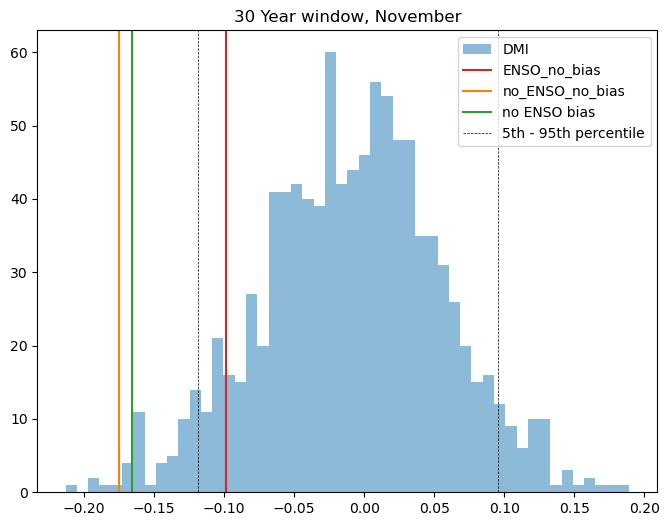

In [20]:
plt.figure(figsize = (8,6))
std_diff.sel(month=11).plot.hist(bins=50,alpha=0.5, label='DMI')
# Add vertical lines for quantiles and other values
plt.axvline(VC_diff.sel(month = 11), c='tab:red', label="ENSO_no_bias")
plt.axvline(OC_diff.sel(month = 11), c='tab:orange', label="no_ENSO_no_bias")
plt.axvline(MC_diff1.sel(month = 11), c='tab:green', label="no ENSO bias")
plt.axvline(quants.sel(month = 11)[0], c='k', ls='--', lw=0.5, label="5th - 95th percentile")
plt.axvline(quants.sel(month = 11)[1], c='k', ls='--', lw=0.5)
plt.legend()
plt.title("30 Year window, November")

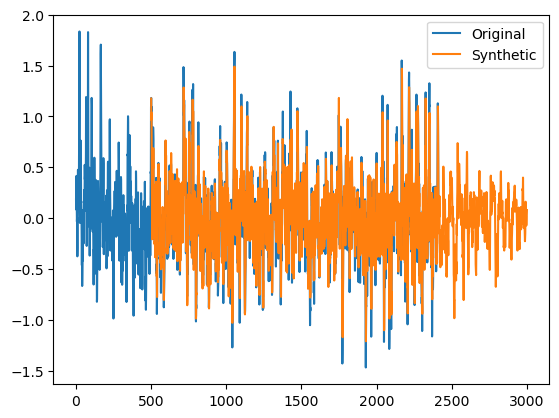

In [37]:
import numpy as np
import pandas as pd
from statsmodels.tsa.ar_model import AutoReg
import matplotlib.pyplot as plt

# Load your time series (replace this line with your data loading logic)
time_series = np.sin(np.linspace(0, 50, 600)) + np.random.normal(scale=0.1, size=600)
time_series = DMI.values
# Determine the order using PACF or AIC/BIC criteria (e.g., order=5)
order = 5

# Fit an AR model of the chosen order
model = AutoReg(time_series, lags=500)
fitted_model = model.fit()

# Generate synthetic time series using the AR model
np.random.seed(42) # for reproducibility
synthetic_series = fitted_model.predict(start=0, end=3000, dynamic=False)

# Plot original and synthetic series
plt.plot(time_series, label='Original')
plt.plot(synthetic_series, label='Synthetic')
plt.legend()
plt.show()

In [ ]:
arcoeffs = arcov(ts,3)
y = filter(1,arcoeffs,randn(length(ts),1)); ##matlab code

In [20]:
from scipy import stats

In [15]:

dmi(ctrl.sel(time = slice('0951-01-01', '1100-01-01'))).groupby('time.month')[10].var()/dmi(MC).groupby('time.month')[10].var()

<xarray.DataArray ()>
array(1.86219826)

In [33]:
import numpy as np
import scipy
from scipy import stats

# Generate two time series for demonstration purposes
np.random.seed(0)  # For reproducibility
series1 = np.random.normal(loc=0, scale=1, size=100)
series2 = np.random.normal(loc=0, scale=2, size=100)

# Perform Levene's test
statistic, p_value = stats.f_oneway(series1,
                                  series2)

print(f"Statistic: {statistic}")
print(f"P-value: {p_value}")

# Interpret the results
if p_value < 0.05:  # You might choose a different significance level
    print("The variances are significantly different.")
else:
    print("The variances are not significantly different.")

Statistic: 0.2029600532557452
P-value: 0.6528350262868573
The variances are not significantly different.


In [31]:
np.std(series1)

1.0078822447165796

In [34]:
stat_p = {}
i = 1
for i in range(1,13,1):
    samp = dmi(MC.sel(time = slice('0951-01-01', '0980-01-01'))).groupby('time.month')[i]
    mn = dmi(ctrl).groupby("time.month")[i]
    stat, p = stats.levene(mn, samp)
    stat_p[i] = [stat, p]
    i = i+1

In [35]:
stat_p

{1: [3.8117222348347664, 0.05211911146747028],
 2: [1.1787182664674156, 0.278763643627049],
 3: [0.007969934146650011, 0.9289421388003621],
 4: [0.09393810831917027, 0.7595088302612735],
 5: [0.6854714171211529, 0.40857476958878036],
 6: [0.26287406133722546, 0.6086488369345078],
 7: [0.228527833435743, 0.6330755938525483],
 8: [3.1215290234536788, 0.07860218732633376],
 9: [3.5543162502413246, 0.060662431948175465],
 10: [5.048455006486464, 0.025605608784133024],
 11: [6.721682675193624, 0.010140592571039931],
 12: [6.454402464706172, 0.011732687244894083]}

In [36]:
stat_p = {}
i = 1
for i in range(1,13,1):
    samp = dmi(VC).groupby('time.month')[i]
    mn = dmi(ctrl).groupby("time.month")[i]
    stat, p = stats.levene(mn, samp)
    stat_p[i] = [stat, p]
    i = i+1
stat_p

{1: [0.7942117660277256, 0.37376499378792327],
 2: [1.0430246842347182, 0.30819674358619115],
 3: [0.6044275838744317, 0.4376960812102586],
 4: [0.4965351243394912, 0.48174254423081453],
 5: [0.0860609999977509, 0.76951149099898],
 6: [0.32927065675998274, 0.5666520101578818],
 7: [1.28684001816629, 0.25781716203883537],
 8: [1.501743232346303, 0.22166218651523686],
 9: [0.01064102649543621, 0.9179299534394096],
 10: [1.8678178268654577, 0.173065499877328],
 11: [3.325564284770259, 0.06951412480123755],
 12: [0.01396985501069226, 0.9060174396191405]}

In [37]:
stat_p = {}
i = 1
for i in range(1,13,1):
    samp = dmi(OC).groupby('time.month')[i]
    mn = dmi(ctrl).groupby("time.month")[i]
    stat, p = stats.levene(mn, samp)
    stat_p[i] = [stat, p]
    i = i+1
stat_p

{1: [0.3163313617470736, 0.5743708945415894],
 2: [3.632987010619801, 0.057897199639045695],
 3: [0.0833872933246277, 0.7730197034484989],
 4: [0.0009955069075871159, 0.9748570799518089],
 5: [1.2157133810565384, 0.2713609473521591],
 6: [3.396677069395201e-05, 0.9953549477574496],
 7: [0.18862427084402883, 0.6644730309280837],
 8: [0.00834957659223198, 0.9272736966529241],
 9: [2.7561920186032993, 0.09824724078635266],
 10: [6.498394768187805, 0.011450953273282912],
 11: [4.4648984413634984, 0.03568069411095065],
 12: [0.5283331377924524, 0.46805085590098716]}

In [38]:
DMI_strength = DMI.groupby('time.month').std('time')

In [44]:
from scipy import stats

In [26]:
stats.kstest(DMI, dmi(VC))

KstestResult(statistic=0.04311774461028192, pvalue=0.5884856268731153, statistic_location=-0.03148082, statistic_sign=1)

In [23]:
DMI

<xarray.DataArray (time: 2412)>
array([0.18244019, 0.08512398, 0.1274277 , ..., 0.82120407, 0.37125218,
       0.13151374], dtype=float32)
Coordinates:
  * time     (time) object 0950-01-16 12:00:00 ... 1150-12-16 12:00:00

(array([  2.,   9.,  12.,  46.,  60., 128., 229., 368., 460., 403., 300.,
        159.,  86.,  55.,  38.,  24.,  17.,   8.,   5.,   3.]),
 array([-1.4688089 , -1.303561  , -1.1383132 , -0.97306526, -0.80781734,
        -0.6425695 , -0.4773216 , -0.3120737 , -0.14682584,  0.01842204,
         0.18366992,  0.3489178 ,  0.5141657 ,  0.67941356,  0.8446615 ,
         1.0099094 ,  1.1751572 ,  1.3404051 ,  1.505653  ,  1.6709008 ,
         1.8361487 ], dtype=float32),
 <BarContainer object of 20 artists>)

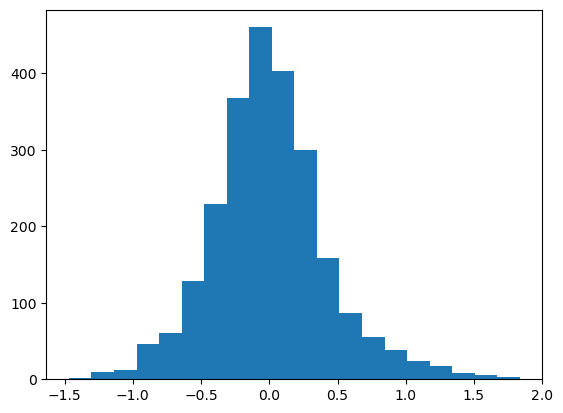

In [19]:
DMI.plot.hist(bins = 20)

I want to take the DMI for 30 random years, and replace thjem, a repeat for 1000 cycles.

In [47]:
def plot_index_ranges_sintex(index):
    #setp 0 get the index
    da = index(s_ctrl)
    index_std_dev = da.groupby('time.month').std('time')
    # Step 1: Number of iterations
    num_iterations = 1000
    # Step 2 and 3: Loop over the iterations
    std_deviations = []
    for _ in range(num_iterations):
        # Step 2: Randomly select 30 years with replacement
        random_years = np.random.choice(da['time.year'], size=30, replace=True)

        # Step 3: Calculate the standard deviation for the selected 30 years
        selected_years_data = da.sel(time=np.isin(da['time.year'], random_years))
        std_dev = selected_years_data.groupby('time.month').std(dim='time')

        # Step 4: Store the standard deviation value
        std_deviations.append(std_dev)

    # Step 5: Calculate the 5th and 95th percentiles
    std_deviations = xr.concat(std_deviations, dim='iterations')
    percentiles = std_deviations.quantile([0.05, 0.95], dim = 'iterations')
    #now we can produe the plot:
    plt.figure(figsize = (10,6))
    plt.errorbar(index_std_dev.month, index_std_dev, yerr=[index_std_dev-percentiles[0], percentiles[1]-index_std_dev]
                 , fmt='-o', capsize=5, label = 'CTRL')
    index(s_oc).groupby('time.month').std('time').plot(label = "no_ENSO_no_bias")
    index(s_mc).groupby('time.month').std('time').plot(label = "no_ENSO")
    plt.xlabel('month')
    plt.ylabel('standard deviation')
    plt.grid(True)
    plt.legend()
    return

In [48]:
def plot_index_ranges(index):
    #setp 0 get the index
    da = index(ctrl)
    index_std_dev = da.groupby('time.month').std('time')
    # Step 1: Number of iterations
    num_iterations = 1000
    # Step 2 and 3: Loop over the iterations
    std_deviations = []
    for _ in range(num_iterations):
        # Step 2: Randomly select 30 years with replacement
        random_years = np.random.choice(da['time.year'], size=68, replace=True)

        # Step 3: Calculate the standard deviation for the selected 30 years
        selected_years_data = da.sel(time=np.isin(da['time.year'], random_years))
        std_dev = selected_years_data.groupby('time.month').std(dim='time')

        # Step 4: Store the standard deviation value
        std_deviations.append(std_dev)

    # Step 5: Calculate the 5th and 95th percentiles
    std_deviations = xr.concat(std_deviations, dim='iterations')
    percentiles = std_deviations.quantile([0.05, 0.95], dim = 'iterations')
    #now we can produe the plot:
    plt.figure(figsize = (10,6))
    plt.errorbar(index_std_dev.month, index_std_dev, yerr=[index_std_dev-percentiles[0], percentiles[1]-index_std_dev]
                 , fmt='-o', capsize=5, label = 'CTRL')
    index(OC.sel(time=slice("0953-01-01", "1020-12-31"))).groupby('time.month').std('time').plot(label = "no_ENSO_no_bias")
    index(MC.sel(time=slice("0953-01-01", "1020-12-31"))).groupby('time.month').std('time').plot(label = "no_ENSO")
    index(VC.sel(time=slice("0953-01-01", "1020-12-31"))).groupby('time.month').std('time').plot(label = "ENSO_no_bias")
    plt.xlabel('month')
    plt.ylabel('standard deviation')
    plt.grid(True)
    plt.legend()
    return

In [49]:
def wtio(DS):
    WTIO = ssta(DS).sel(latitude=slice(-10, 10),longitude=slice(50, 70)).mean(['latitude', 'longitude'])
    return  WTIO
def setio(DS):
    SETIO = ssta(DS).sel(latitude=slice(-10, 0),longitude=slice(90, 110)).mean(['latitude', 'longitude'])
    return SETIO

Text(0.5, 1.0, 'WTIO strength in SINTEX runs')

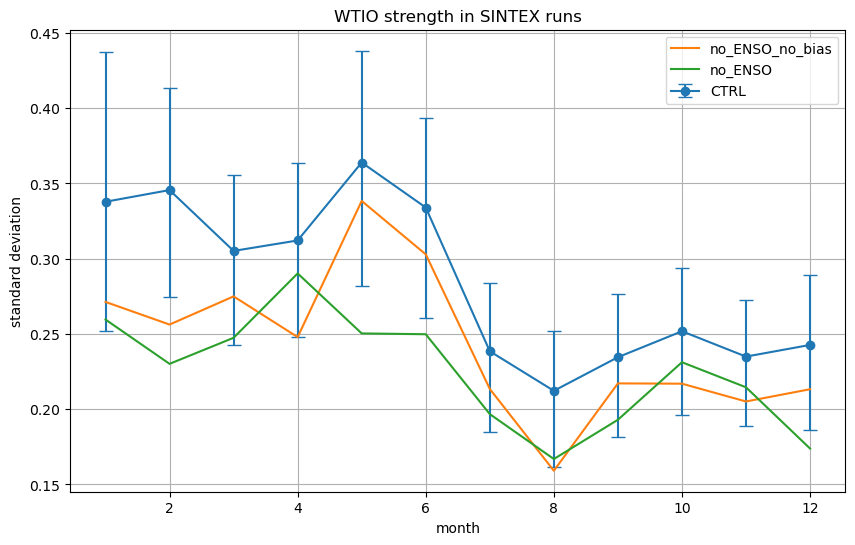

In [64]:
plot_index_ranges_sintex(wtio)
plt.title('WTIO strength in SINTEX runs')

Text(0.5, 1.0, 'SETIO strength in SINTEX runs')

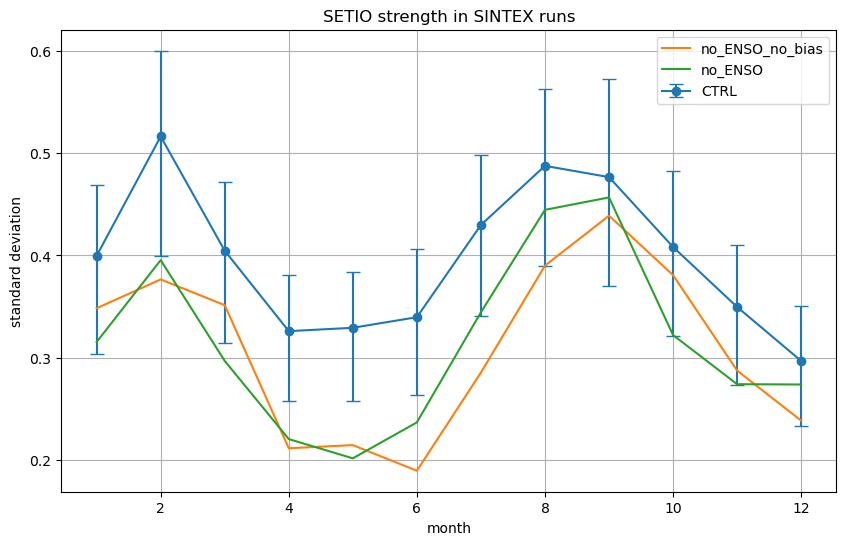

In [65]:
plot_index_ranges_sintex(setio)
plt.title('SETIO strength in SINTEX runs')

Text(0.5, 1.0, 'DMI strength in SINTEX runs')

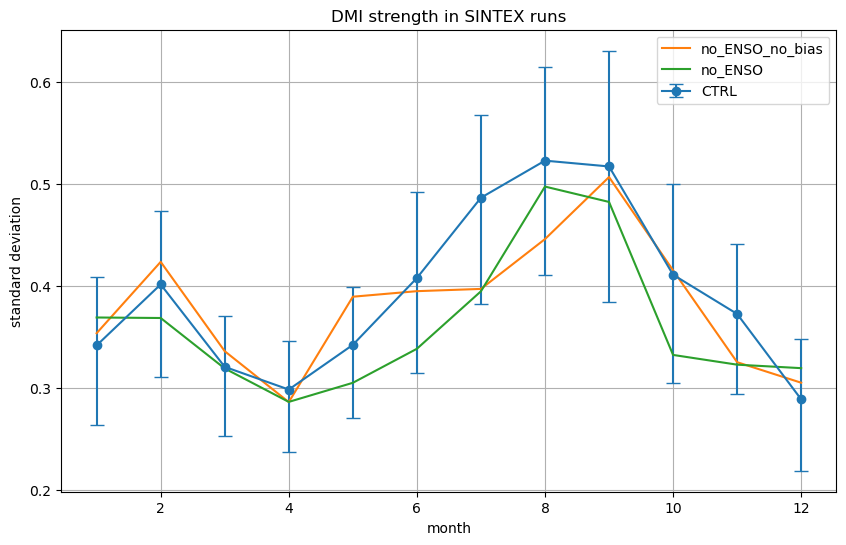

In [50]:
plot_index_ranges_sintex(dmi)
plt.title('DMI strength in SINTEX runs')

Text(0.5, 1.0, 'DMI strength in ACCESS-CM2 runs')

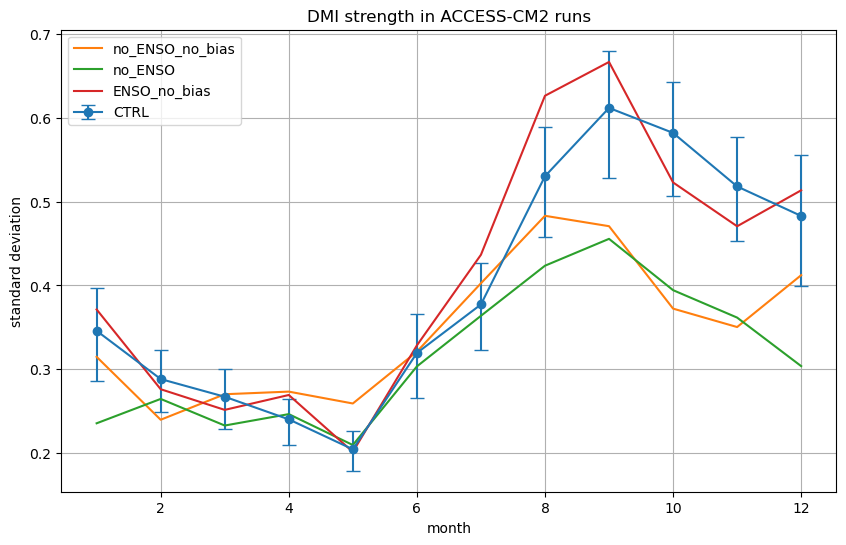

In [51]:
plot_index_ranges(dmi)
plt.title('DMI strength in ACCESS-CM2 runs')

Text(0.5, 1.0, 'WTIO strength in ACCESS-CM2 runs')

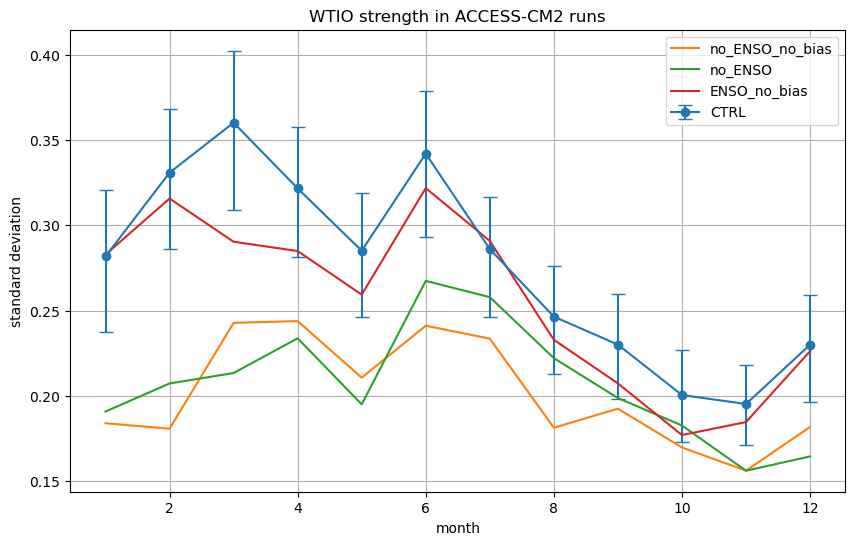

In [62]:
plot_index_ranges(wtio)
plt.title('WTIO strength in ACCESS-CM2 runs')

Text(0.5, 1.0, 'SETIO strength in ACCESS-CM2 runs')

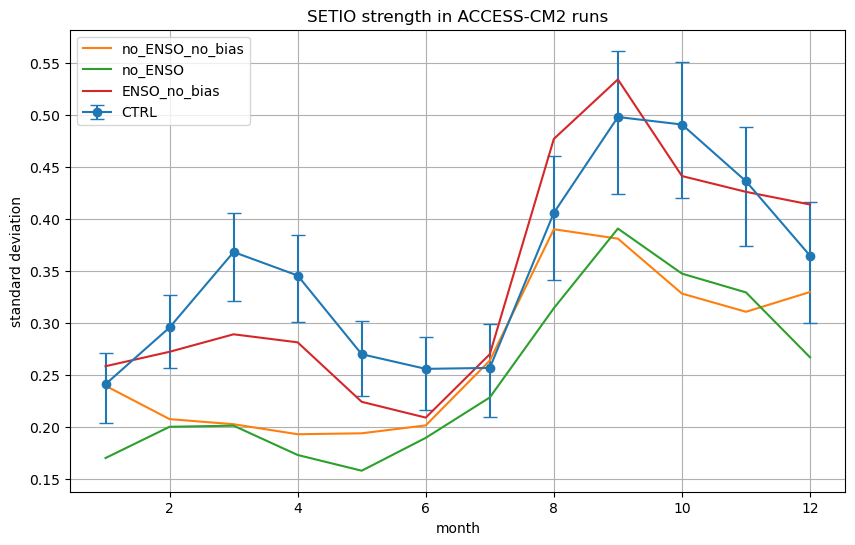

In [63]:
plot_index_ranges(setio)
plt.title('SETIO strength in ACCESS-CM2 runs')

Text(0.5, 1.0, 'DMI strength in ACCESS-CM2 runs')

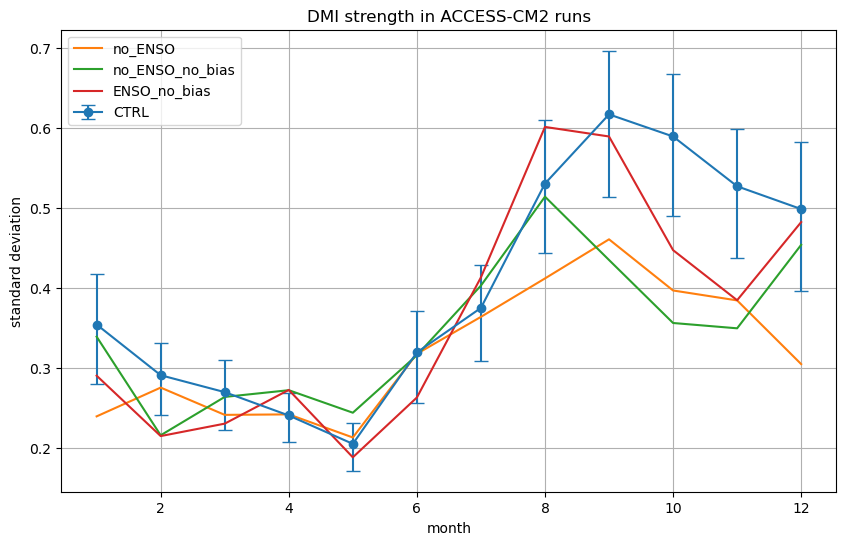

In [37]:
plot_index_ranges(dmi)
plt.title('DMI strength in ACCESS-CM2 runs')

Text(0.5, 1.0, 'Subtropical dipole strength in ACCESS-CM2 runs')

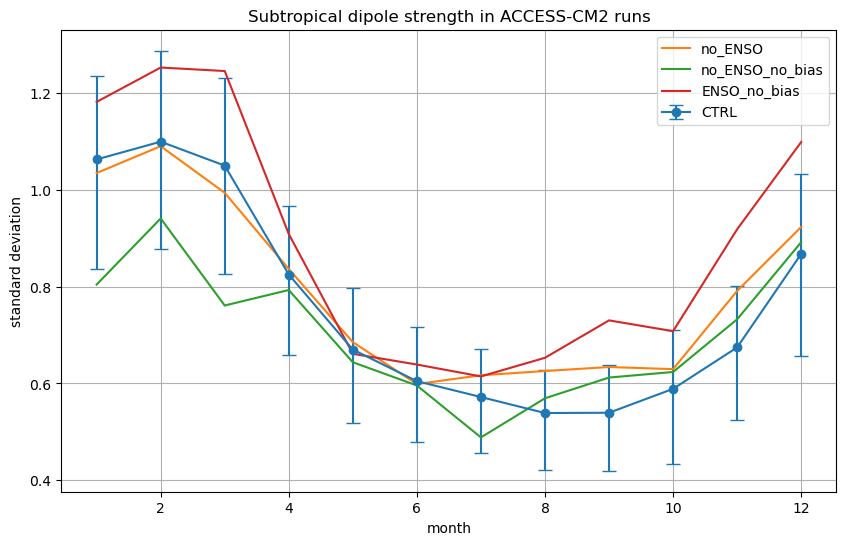

In [27]:
plot_index_ranges(siod)
plt.title('Subtropical dipole strength in ACCESS-CM2 runs')


Text(0.5, 1.0, 'Ningaloo Nino strength in ACCESS-CM2 runs')

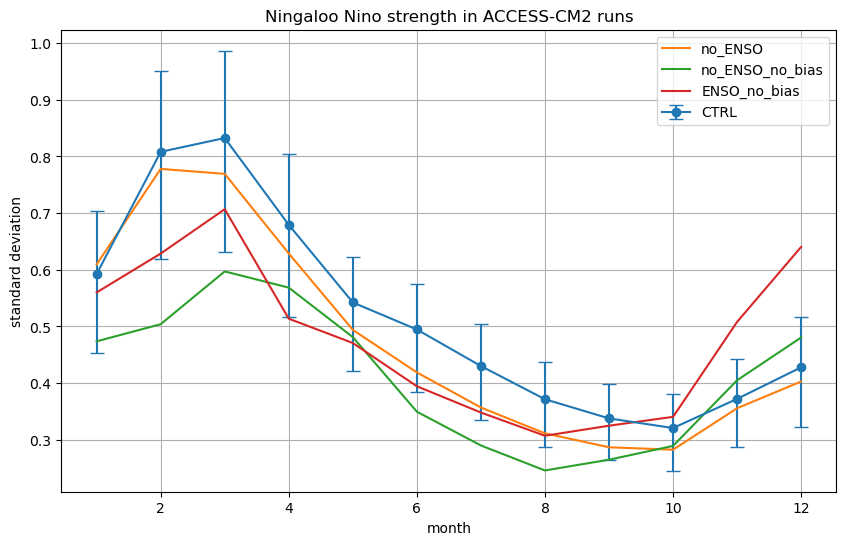

In [28]:
plot_index_ranges(Ningaloo2)
plt.title('Ningaloo Nino strength in ACCESS-CM2 runs')


Text(0.5, 1.0, 'IOBM strength in ACCESS-CM2 runs')

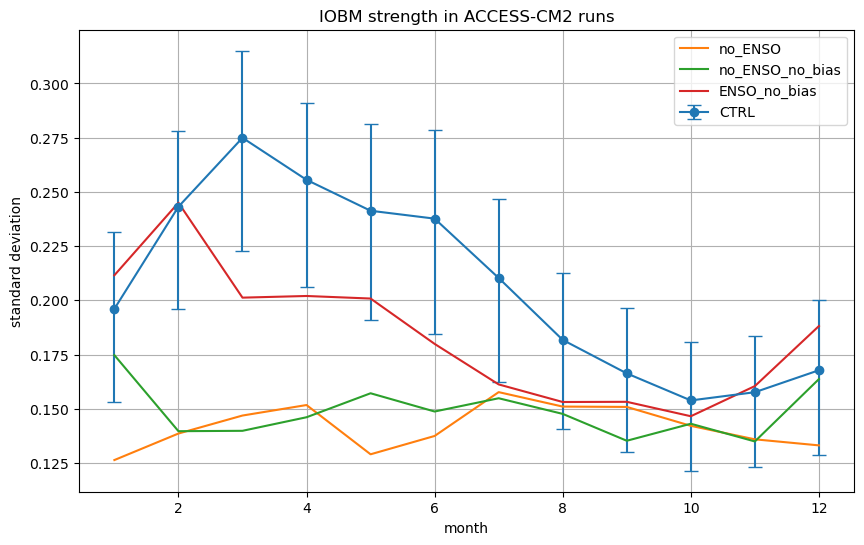

In [29]:
plot_index_ranges(iobm)
plt.title('IOBM strength in ACCESS-CM2 runs')

Text(0.5, 1.0, 'NINO34 strength in ACCESS-CM2 runs')

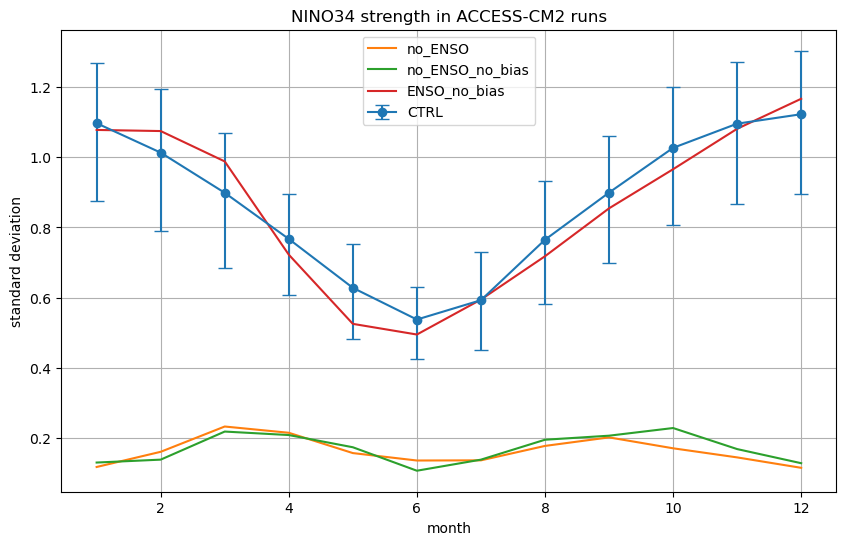

In [30]:
plot_index_ranges(NINO34)
plt.title('NINO34 strength in ACCESS-CM2 runs')

Text(0.5, 1.0, 'Subtropical dipole strength in SINTEX runs')

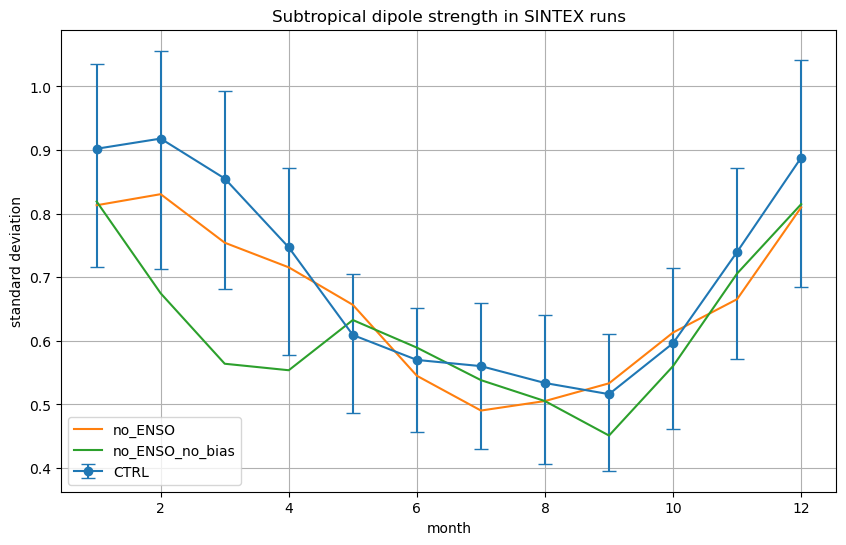

In [31]:
plot_index_ranges_sintex(siod)
plt.title('Subtropical dipole strength in SINTEX runs')


Text(0.5, 1.0, 'Ningaloo Nino strength in SINTEX runs')

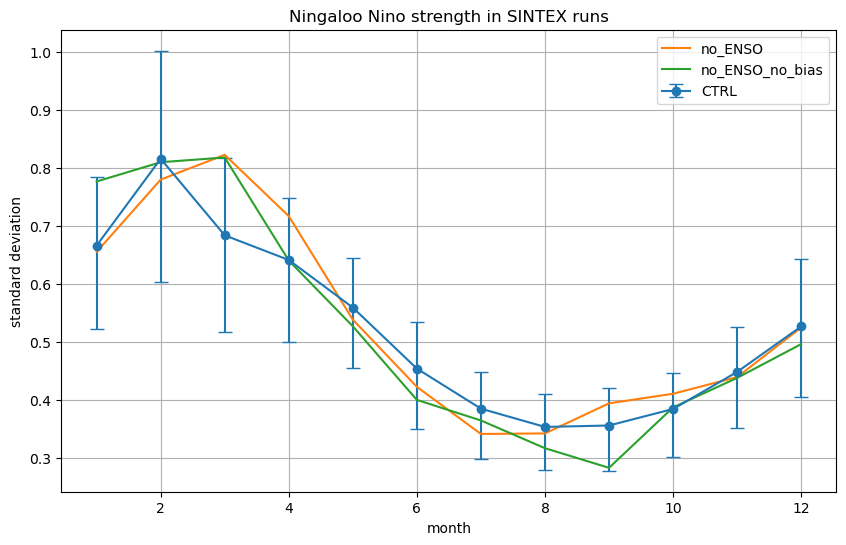

In [34]:
plot_index_ranges_sintex(Ningaloo2)
plt.title('Ningaloo Nino strength in SINTEX runs')


Text(0.5, 1.0, 'IOBM strength in SINTEX runs')

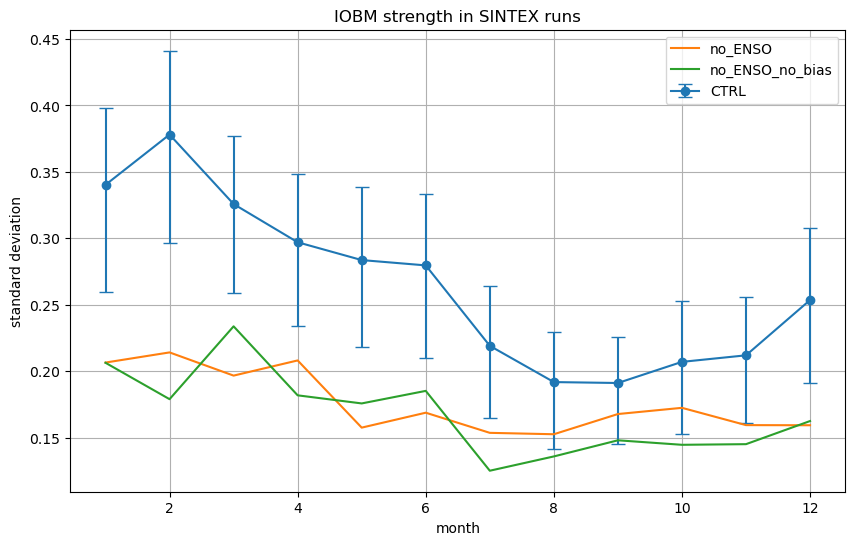

In [35]:
plot_index_ranges_sintex(iobm)
plt.title('IOBM strength in SINTEX runs')


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/matplotlib/axes/_axes.py:1148: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/matplotlib/axes/_axes.py:1149: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


Text(0.5, 1.0, 'Nino34 strength in SINTEX runs')

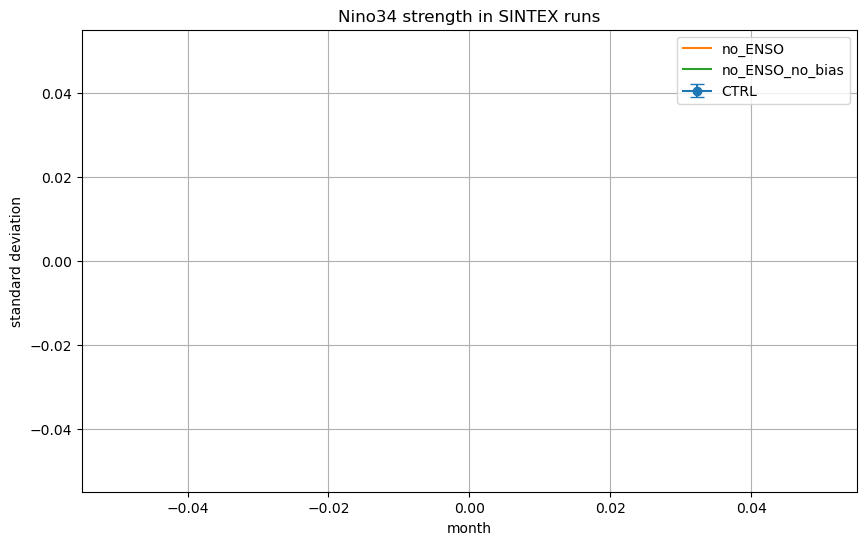

In [36]:
plot_index_ranges_sintex(NINO34)
plt.title('Nino34 strength in SINTEX runs')

In [42]:
def linear_trend(x, y):
    pf = np.polyfit(x, y, 1)
    return xr.DataArray(pf[0])

In [43]:
def regress(var1, var2):
    slope = xr.apply_ufunc(linear_trend,
                        var1, var2,
                        vectorize=True,
                        dask = 'parallelized',
                        input_core_dims=[['time'], ['time']],# reduce along 'model'
                        )
    return slope

In [44]:
def plot_regression(FN, DS):
    slope = regress(FN(DS), ssta(DS))
    plt.figure(figsize = (10,6))
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

    slope.plot.contourf(ax=ax, transform=ccrs.PlateCarree(),
                            vmin = -1, vmax = 1, levels = 10, extend = 'both',  cmap = "RdBu_r")
    ax.coastlines(color = 'k')
    ax.gridlines()
    ax.set_facecolor('grey')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    #ax.set_extent([60, 290, -40, 40], crs=ccrs.PlateCarree())
    return

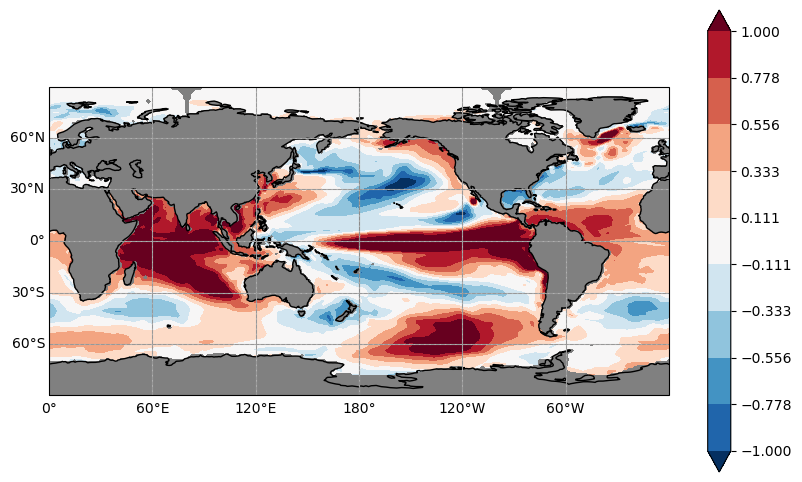

In [45]:
plot_regression(iobm, ctrl)

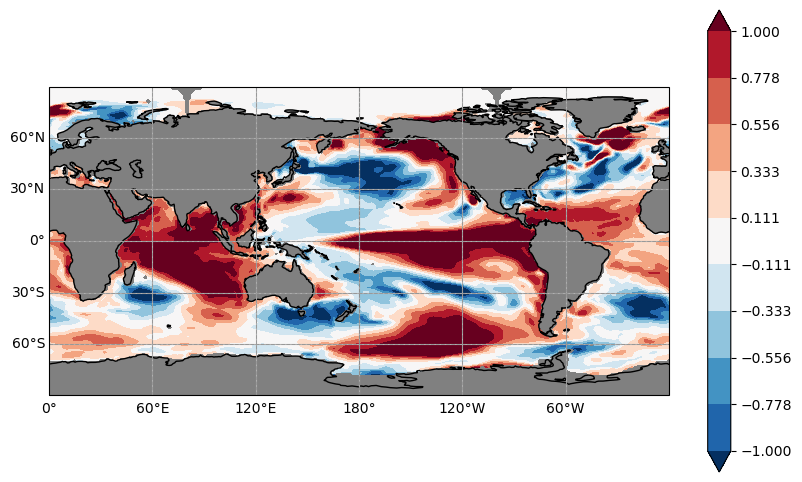

In [46]:
plot_regression(iobm, VC)

In [25]:
#now lets take 30 year chunks for simplicity

In [26]:
def create_moving_windows(da, len_window = 50):
    """
    Selects moving 50-year windows from an xarray DataArray with monthly time steps.
    Consective years

    Args:
        da (xarray.DataArray): The data array to select windows from.
        num_windows (int): The number of windows to select.
        len_window (int): length of window in years

    Returns:
        A list of xarray DataArray objects, each containing a 50-year window of the original data.
    """
    windows = []
    start_year = da.time.dt.year.min().data
    end_year = da.time.dt.year.max().data - len_window
    for i in range(0, int(len(da.time)/12)-len_window, 1):
        start_date = cftime.DatetimeGregorian(start_year, 1, 1)
        end_date = cftime.DatetimeGregorian(start_year + len_window, 12, 31)
        window = da.sel(time=slice(start_date, end_date))
        window = window.assign_coords({"chunk":i})
        #window = window.std('time')
        if i ==0:
            win_da = window
        else:
            win_da = xr.concat([win_da,window], dim = "chunk")
        #windows.append(window)
        start_year = start_year+1

    return win_da

In [27]:
chu30 = create_moving_windows(DMI, len_window=30)#30 year moving windows of the DMI

In [29]:
#now get the monthly standard deviation of each chunk, this is the error maybe

In [54]:
DMI_strength = DMI.groupby('time.month').std('time')

In [92]:
error = chu30.groupby('time.month').std('time').std("chunk")

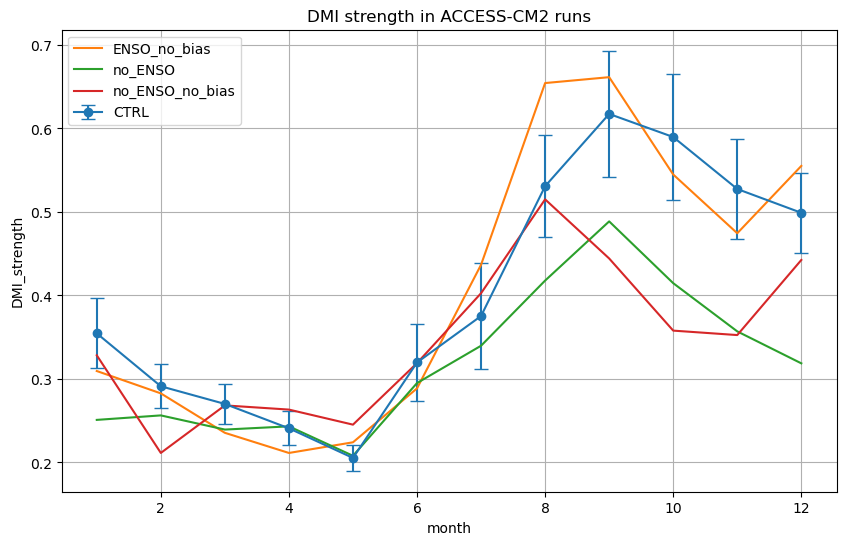

In [94]:
# Plot the line chart with error bars
plt.figure(figsize=(10, 6))
plt.errorbar(DMI_strength.month, DMI_strength, yerr=error.values, fmt='-o', capsize=5, label = 'CTRL')

dmi(VC).groupby('time.month').std('time').plot(label = "ENSO_no_bias")
dmi(MC).groupby('time.month').std('time').plot(label = "no_ENSO")
dmi(OC).groupby('time.month').std('time').plot(label = "no_ENSO_no_bias")

plt.xlabel('month')
plt.ylabel('DMI_strength')
plt.title('DMI strength in ACCESS-CM2 runs')
plt.grid(True)
plt.legend()
plt.show()

In [56]:
#now write a fucntion to output bias and to optioanlly plot
def sst_bias(model, obs, freq=None, plot=None, temp_scale = 2):
    """
    Lorem ipsum dolor sit amet, consetetur sadipscing elitr,
    sed diam nonumy eirmod tempor invidunt ut labore et dolore magna aliquyam
    
    Parameters
    ----------
    model : argument of type int
        DataArray of model run 
    obs : argument of type int
        Lorem ipsum dolor sit amet
    freq : {‘monthly’, ‘annual’}, optional
        if None default to 'monthly'
    plot : True or False
        if true, plot is made, if false then no
    temp_scale : 2 (optional)
        set to 2 automatically, sets vmin vmax

    """
    #check frequency of sampling, defaukt to monthly if not specified
    if freq == None:
        freq = 'monthly'
    if plot == None:
        plot = False
    #check what the obs file is time or month already
    if obs.dims[0] == "time":
        obs_mon = obs.groupby('time.month').mean('time')
        obs_mn = obs.mean('time')
    else:
        obs_mon = obs 
        obs_mn = obs.mean('month')
    
    
    #calculate the bias
    if freq == "monthly":
        bias = (model.groupby('time.month').mean('time') - obs_mon)
        if plot == True:
            fg = bias.plot.contourf(col='month', col_wrap = 4,  transform=ccrs.PlateCarree(),
                                 subplot_kws={"projection": ccrs.PlateCarree(central_longitude = 180)}, 
                                  figsize=(20,8), facecolor = 'white', vmin = -1*temp_scale, vmax = temp_scale, levels =10, extend = 'both',  cmap = 'RdBu_r',
                                    cbar_kwargs=dict(label='Bias ($^\\circ$C)'))
            for i, ax in enumerate(fg.axes.flat):
                ax.coastlines()
                #ax.set_facecolor('grey')
                gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                                  linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
                if i in [0,1,2,3,4,5,6,7]:
                    gl.bottom_labels = False
                if i in [1,2,3,5,6,7,9,10,11]:
                    gl.left_labels = False
                gl.top_labels = False
                gl.right_labels = False               
            #now add the month labels\n",
            titles =['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun','Jul',
                     'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
            for ax,title in zip(fg.axes.flatten(),titles):
                ax.set_title(title )
            return
        elif plot == False:
            return bias
    elif freq == "annual":
        bias = (model.mean('time') - obs_mn)
        if plot == True:
            plt.figure(figsize = (12,8))
            ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
            bias.plot.contourf(ax=ax, vmin = -1*temp_scale, vmax = temp_scale, cmap = "RdBu_r", levels = 10, extend = 'both',
                   transform=ccrs.PlateCarree(), cbar_kwargs=dict(label='Bias ($^\\circ$C)'))
            ax.set_title('Annual mean SST bias')
            ax.coastlines(color = 'k')
            ax.gridlines()
            #ax.set_facecolor('grey')
            gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                                  linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
            gl.top_labels = False
            gl.right_labels = False
            return 
        elif plot == False:
            return bias

Text(0.5, 1.0, 'ENSO no bias - CTRL')

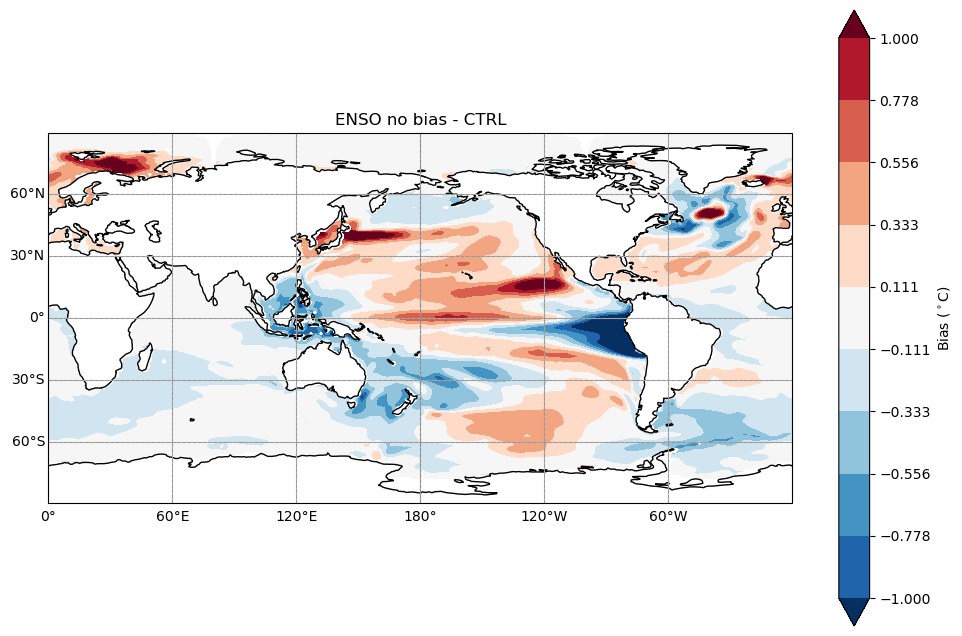

In [61]:
sst_bias(VC.sel(time = slice("0951-01-01", "1000-12-31")), ctrl, freq = "annual", plot = True, temp_scale=1)
plt.title("ENSO no bias - CTRL")

Text(0.5, 1.0, 'No ENSO no bias - CTRL')

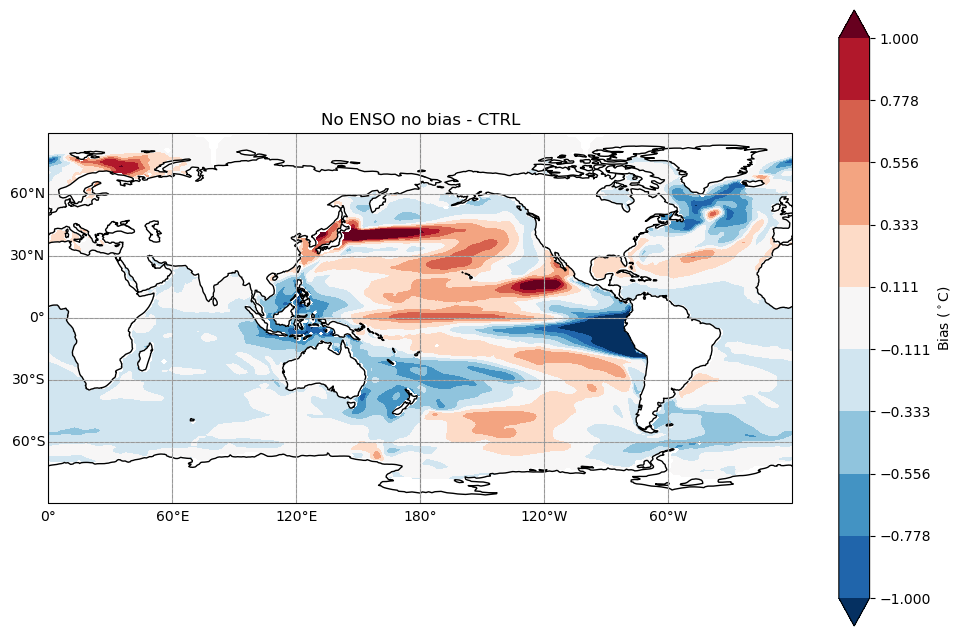

In [62]:
sst_bias(OC.sel(time = slice("0951-01-01", "1000-12-31")), ctrl, freq = "annual", plot = True, temp_scale=1)
plt.title("No ENSO no bias - CTRL")

Text(0.5, 1.0, 'No ENSO - CTRL')

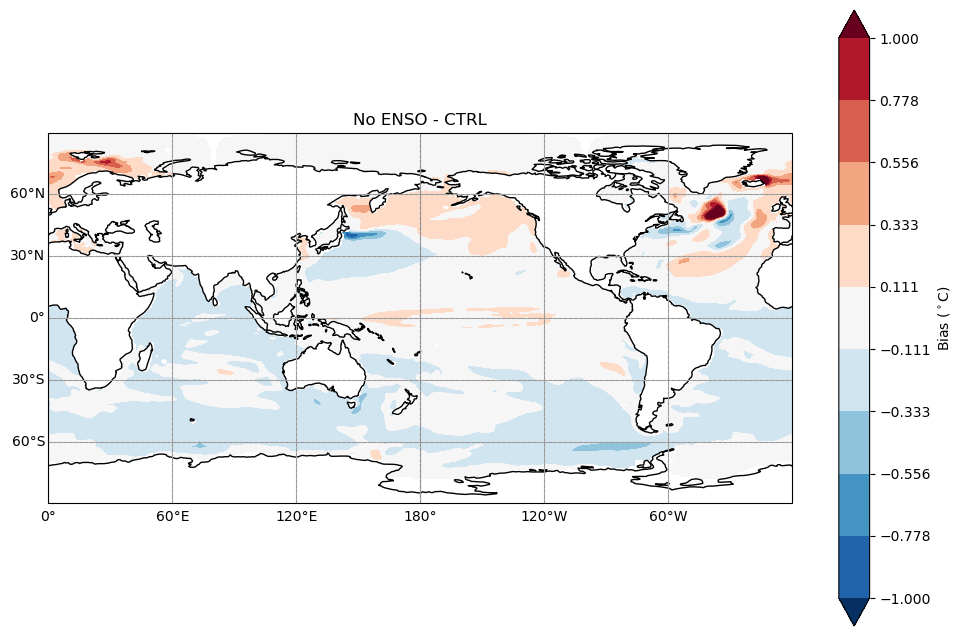

In [63]:
sst_bias(MC.sel(time = slice("0951-01-01", "1000-12-31")), ctrl, freq = "annual", plot = True, temp_scale=1)
plt.title("No ENSO - CTRL")